## Efficientnet Adversarial Learning with RKD - WIDER (Class Reduced)

In [3]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import copy
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet

from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss
# from models_package.models import Teacher, Student

# new libraries
from models_package.models import Teacher, Student, CustomResNet18
from torchvision import datasets, transforms, models
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof, load_wider
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss, DD_loss, AD_loss, RKDDistanceLoss, RKDAngleLoss
from utils.misc_tools_rkd import best_lr_rkd, rkd_train_teacher, rkd_train_student_with_distillation, rkd_test_model
from utils.compare_tools_rkd import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison

# Suppress all warnings
warnings.filterwarnings("ignore")

In [4]:
# Hyperparameters
learning_rate = 0.001379 # 0.096779
epochs = 300
epochs_pretrain = 3 #3
epochs_optimal_lr = 3 #5
patience_teacher = 7
patience_student = 10
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
lmda = 3
batch_size = 64
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = False # True

# list of lambda values to loop through for grid search
lmda_list_student = [0,3,5]
lmda_list_teacher = [0]
# lmda_list_teacher = [0,3,5,10]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16 #len(class_labels)
class_names_new = [f"Class {label}" for label in range(num_classes)]

# Create directory and file path to save all outputs
output_dir = f'./runs_{datetime.now().strftime("%Y_%m_%d_%H_%M")}'
os.makedirs(output_dir, exist_ok=True)

In [5]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Assuming your JSON file is named 'your_file.json'
file_path = 'data/WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [7]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(16):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [8]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [9]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'data/WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'data/WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "data/WIDER/Image/train" in img_path:
            label_str = img_path.split("data/WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "data/WIDER/Image/test" in img_path:
            label_str = img_path.split("data/WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "data/WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("data/WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [10]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [11]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [12]:
train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')


if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [13]:
len(train_dataset)

10324

# Start Training Process

In [14]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [15]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.classifier = nn.Linear(1536, num_classes)
student_model = torchvision.models.efficientnet_b0(weights=None)
student_model.classifier = nn.Linear(1280, num_classes)

# Load teacher
# teacher_model = torch.load('teacher_model_rkd_wider.pth')
# teacher_model.load_state_dict(torch.load('teacher_model_weights_rkd_wider.pth'))
# torch.save(teacher_model.state_dict(), 'teacher_model_weights_rkd_wider.pth')
# # Load the studnet
# student_model = torch.load('student_model_rkd_prof.pth')
# student_model.load_state_dict(torch.load('student_model_weights_rkd_prof_checkpoint.pth'))
# student_model = student_model.to(device)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [16]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size*2, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()

In [17]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)


In [18]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)


In [19]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
        concatenated_output = torch.cat((student_output, one_hot_labels), dim=1)
        adversary_output = adv(concatenated_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)


In [20]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()


In [21]:
# #### finding the optimal learning rate
# def train_teacher_optimal_lr(model, trainloader, criterion, optimizer, scheduler, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Teacher')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Teacher: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_teacher = train_teacher_optimal_lr(teacher_model, trainloader, criterion_clf, teacher_optimizer, teacher_scheduler, device, epochs_optimal_lr)  
# print(best_lr_teacher)


In [22]:
# #### finding the optimal learning rate
# def train_student_optimal_lr(model, trainloader, criterion, optimizer, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Student')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Student: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_student = train_student_optimal_lr(student_model, trainloader, criterion_clf, student_optimizer, device, epochs_optimal_lr)  
# print(best_lr_student)

In [23]:
best_lr_student = learning_rate
best_lr_teacher = learning_rate

In [24]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [25]:
# This is the adversary training function, where we input the student outputs, 
# with the true labels into the adversary model created previously.
def train_adversary(adv, model, optimizer, trainloader, criterion, epochs):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_batches = 0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs and labels
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            model.eval()
            model.to(device)
            adv.train()
            adv.to(device)
            optimizer.zero_grad()
            # output the student model, join with ohe labels. 
            model_output = model(inputs)
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((model_output, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)

            adversary_loss = criterion(adversary_output, targets)
            adversary_loss.backward()
            epoch_loss += adversary_loss.item()
            epoch_batches += 1
            optimizer.step()
        epoch_loss/=epoch_batches
        print("Average Adversary epoch loss:", epoch_loss)

In [26]:
# Function to train the teacher model


def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((teacher_outputs_detached, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                one_hot_labels_val = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                concatenated_output_val = torch.cat((teacher_outputs_detached_val, one_hot_labels_val), dim=1)
                adversary_output_val = adv(concatenated_output_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")
        
        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(model.state_dict(), f'teacher_model_weights_rkd_prof_checkpoint{lmda}.pth')
            torch.save(model, f'teacher_model_rkd_prof_checkpoint{lmda}.pth')
        else:
            patience_counter += 1 

        # if patience_counter >= patience:
        #     print('Early stopping')
        #     break  
            
        file_path = os.path.join(output_dir, f'teacher_validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epochs}***********')
            
            file.write("Teacher Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nTeacher Val Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        print(f"Data has been appended to {file_path}")
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")
    return val_disparities


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizer, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student, optimizer_adv=None):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        # Train the adversary at the start of each epoch
        train_adversary(adv, student, optimizer_adv, trainloader, adv_criterion, 1)

        student.train()
        student.to(device)
        adv.eval()
        adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # detach student_outputs to avoid exploding gradients by passing same inputs (with gradience) into two different models. 
            studentached = student_outputs.detach()
            # One-hot encode labels and concatenate with student's predictions
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((studentached, one_hot_labels), dim=1)

            # Run the adversarial model on concatenated true labels, and predicted labels
            with torch.no_grad():
                adversary_output = adv(concatenated_output)

            # Calc adversary loss, which is an MSE loss, because this is a regression output. 
            adversary_loss = adv_criterion(adversary_output, targets)
            ce_loss = criterion(student_outputs, labels)
            # kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar

            # RKD Loss
            distance_loss = RKDDistanceLoss()(student_outputs, teacher_outputs)
            angle_loss = RKDAngleLoss()(student_outputs, teacher_outputs)
            
            if lmda != 0:
                loss = ce_loss + 0.1 * (distance_loss + angle_loss) + (ce_loss + 0.1 * (distance_loss + angle_loss))/adversary_loss - lmda * adversary_loss
            else:
                loss = ce_loss + 0.1 * (distance_loss + angle_loss)
    
            # if kd_loss.ndim != 0:
            #     kd_loss = kd_loss.sum()

            # # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # # goal of the model is to have the adversary not predict gender. 
            # if lmda != 0:
            #     loss = (alpha * kd_loss + (1 - alpha) * ce_loss) + (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss - lmda * adversary_loss
            # else:
            #     loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        # print(f'*******Epoch {epoch}: running_recall_with - {running_recall_with/num_batches}  |  running_recall_without - {running_recall_without/num_batches}  |  disparity - {epoch_disparity/num_batches}******')
        student_epoch_losses.append(epoch_loss)

        student.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)

                val_studentached = val_student_outputs.detach()   
                val_one_hot_labels = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                val_concatenated_output = torch.cat((val_studentached, val_one_hot_labels), dim=1)
                
                val_adversary_output = adv(val_concatenated_output)
                val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                val_ce_loss = criterion(val_student_outputs, val_labels)
                # val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
    
                # RKD Loss
                val_distance_loss = RKDDistanceLoss()(val_student_outputs, val_teacher_outputs)
                val_angle_loss = RKDAngleLoss()(val_student_outputs, val_teacher_outputs)
                if lmda != 0:
                    val_loss = \
                        val_ce_loss + 0.1 * (val_distance_loss + val_angle_loss) + (val_ce_loss + 0.1 * (val_distance_loss + val_angle_loss))/val_adversary_loss - lmda * val_adversary_loss
                else:
                    val_loss = val_ce_loss + 0.1 * (val_distance_loss + val_angle_loss)
                
                # if val_kd_loss.ndim != 0:
                #     val_kd_loss = val_kd_loss.sum()
                # if lmda != 0:
                #     val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) + (alpha * val_kd_loss + (1 - alpha) * val_ce_loss)/val_adversary_loss - lmda * val_adversary_loss
                # else:
                #     val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(student.state_dict(), f'student_model_weights_rkd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, f'student_model_rkd_wider_checkpoint_lambda{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
    
        file_path = os.path.join(output_dir, f'validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epochs}***********')
            
            file.write("Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nVal Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        
        print(f"Data has been appended to {file_path}")
    plot_loss_curve(val_losses)
                
    return best_epoch_mean_abs_disparity

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 1/30*****
*****Train Loss:  1.692031 Val Loss:  1.373034*****
*****Validation Accuracy: 58.93%*****
*****Total Avg Disparity: 0.18991072717396362*****

Class Team_Sports: Recall Difference = 0.0963686519242074
Class Celebration: Recall Difference = 0.07219662058371734
Class Parade: Recall Difference = 0.029041566893841853
Class Waiter_Or_Waitress: Recall Difference = -0.10439560439560436
Class Individual_Sports: Recall Difference = -0.18668954996186127
Class Surgeons: Recall Difference = -0.22619047619047616
Class Spa: Recall Difference = -0.673469387755102
Class Law_Enforcement: Recall Difference = 0.10550401978973406
Class Business: Recall Difference = 0.11245748299319736
Class Dresses: Recall Difference = -0.6605769230769232
Class Water Activities: Recall Difference = 0.13089542036910462
Class Picnic: Recall Difference = -0.29090909090909095
Class Rescue: Recall Difference = 0.1006493506493506
Class Cheering: Recall Difference = -0.03465955701394588
Class Performance_And_

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 2/30*****
*****Train Loss:  1.245096 Val Loss:  1.388499*****
*****Validation Accuracy: 59.11%*****
*****Total Avg Disparity: 0.1682305801939351*****

Class Team_Sports: Recall Difference = 0.1032650477094923
Class Celebration: Recall Difference = 0.054531490015360895
Class Parade: Recall Difference = 0.01780561183766194
Class Waiter_Or_Waitress: Recall Difference = -0.1295133437990582
Class Individual_Sports: Recall Difference = -0.15690312738367662
Class Surgeons: Recall Difference = -0.10416666666666669
Class Spa: Recall Difference = -0.4897959183673469
Class Law_Enforcement: Recall Difference = 0.13506493506493505
Class Business: Recall Difference = 0.03188775510204078
Class Dresses: Recall Difference = -0.729326923076923
Class Water Activities: Recall Difference = -0.07347915242652081
Class Picnic: Recall Difference = -0.3090909090909092
Class Rescue: Recall Difference = 0.12337662337662325
Class Cheering: Recall Difference = -0.029532403609515978
Class Performance_And_

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 3/30*****
*****Train Loss:  1.012808 Val Loss:  1.408750*****
*****Validation Accuracy: 61.36%*****
*****Total Avg Disparity: 0.1673172768696746*****

Class Team_Sports: Recall Difference = 0.07441324107990777
Class Celebration: Recall Difference = 0.08986175115207373
Class Parade: Recall Difference = -0.010130779149014502
Class Waiter_Or_Waitress: Recall Difference = -0.22135007849293564
Class Individual_Sports: Recall Difference = -0.14919908466819243
Class Surgeons: Recall Difference = -0.038690476190476164
Class Spa: Recall Difference = -0.5102040816326531
Class Law_Enforcement: Recall Difference = 0.13011750154607304
Class Business: Recall Difference = 0.021045918367346927
Class Dresses: Recall Difference = -0.65625
Class Water Activities: Recall Difference = 0.08498519024834827
Class Picnic: Recall Difference = -0.6
Class Rescue: Recall Difference = -0.009490509490509447
Class Cheering: Recall Difference = -0.056808859721082905
Class Performance_And_Entertainment: Reca

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 4/30*****
*****Train Loss:  0.830222 Val Loss:  1.468092*****
*****Validation Accuracy: 61.56%*****
*****Total Avg Disparity: 0.16690992348689548*****

Class Team_Sports: Recall Difference = 0.03590648035092481
Class Celebration: Recall Difference = -0.022273425499232002
Class Parade: Recall Difference = 0.006876650089027936
Class Waiter_Or_Waitress: Recall Difference = -0.03453689167974883
Class Individual_Sports: Recall Difference = -0.12044241037376058
Class Surgeons: Recall Difference = 0.08630952380952384
Class Spa: Recall Difference = -0.673469387755102
Class Law_Enforcement: Recall Difference = 0.11205936920222637
Class Business: Recall Difference = 0.0189200680272108
Class Dresses: Recall Difference = -0.6437500000000002
Class Water Activities: Recall Difference = 0.09227614490772396
Class Picnic: Recall Difference = -0.4363636363636364
Class Rescue: Recall Difference = 0.04395604395604402
Class Cheering: Recall Difference = -0.0908531583264971
Class Performance_And_

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 5/30*****
*****Train Loss:  0.697306 Val Loss:  1.456642*****
*****Validation Accuracy: 62.71%*****
*****Total Avg Disparity: 0.1397862868022821*****

Class Team_Sports: Recall Difference = 0.07647085424863198
Class Celebration: Recall Difference = -0.028417818740399503
Class Parade: Recall Difference = -0.10757045496408169
Class Waiter_Or_Waitress: Recall Difference = -0.08948194662480391
Class Individual_Sports: Recall Difference = -0.1502288329519451
Class Surgeons: Recall Difference = -0.09523809523809518
Class Spa: Recall Difference = 0.24489795918367352
Class Law_Enforcement: Recall Difference = 0.05528756957328396
Class Business: Recall Difference = -0.052721088435374264
Class Dresses: Recall Difference = -0.710576923076923
Class Water Activities: Recall Difference = 0.01777170198222844
Class Picnic: Recall Difference = -0.14545454545454545
Class Rescue: Recall Difference = 0.09440559440559443
Class Cheering: Recall Difference = -0.19667760459392952
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 6/30*****
*****Train Loss:  0.578145 Val Loss:  1.606289*****
*****Validation Accuracy: 59.02%*****
*****Total Avg Disparity: 0.16719860833812442*****

Class Team_Sports: Recall Difference = 0.07029801474245934
Class Celebration: Recall Difference = -0.023425499231950864
Class Parade: Recall Difference = 0.07938846933136856
Class Waiter_Or_Waitress: Recall Difference = -0.08555729984301419
Class Individual_Sports: Recall Difference = -0.10247902364607175
Class Surgeons: Recall Difference = -0.1830357142857143
Class Spa: Recall Difference = -0.7755102040816327
Class Law_Enforcement: Recall Difference = 0.05293753865182449
Class Business: Recall Difference = 0.03125
Class Dresses: Recall Difference = -0.6024038461538463
Class Water Activities: Recall Difference = 0.09239006607427669
Class Picnic: Recall Difference = -0.1818181818181819
Class Rescue: Recall Difference = 0.06643356643356646
Class Cheering: Recall Difference = -0.05168170631665303
Class Performance_And_Entertainm

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 7/30*****
*****Train Loss:  0.467196 Val Loss:  1.674609*****
*****Validation Accuracy: 59.80%*****
*****Total Avg Disparity: 0.16612725427717284*****

Class Team_Sports: Recall Difference = 0.018789852123185513
Class Celebration: Recall Difference = 0.08947772657450076
Class Parade: Recall Difference = -0.09148400564867709
Class Waiter_Or_Waitress: Recall Difference = -0.05572998430141285
Class Individual_Sports: Recall Difference = -0.17890922959572853
Class Surgeons: Recall Difference = -0.023809523809523836
Class Spa: Recall Difference = -0.673469387755102
Class Law_Enforcement: Recall Difference = 0.055163883735312336
Class Business: Recall Difference = -0.11373299319727881
Class Dresses: Recall Difference = -0.6504807692307693
Class Water Activities: Recall Difference = 0.09295967190704013
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = 0.042957042957042946
Class Cheering: Recall Difference = -0.15463494667760463
Class Performan

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 8/30*****
*****Train Loss:  0.407095 Val Loss:  1.704651*****
*****Validation Accuracy: 61.73%*****
*****Total Avg Disparity: 0.14448313651580236*****

Class Team_Sports: Recall Difference = 0.09367792701126043
Class Celebration: Recall Difference = 0.0721966205837174
Class Parade: Recall Difference = -0.02529624854178192
Class Waiter_Or_Waitress: Recall Difference = -0.10361067503924648
Class Individual_Sports: Recall Difference = -0.09443173150266959
Class Surgeons: Recall Difference = -0.1726190476190475
Class Spa: Recall Difference = 0.3877551020408163
Class Law_Enforcement: Recall Difference = 0.03722943722943728
Class Business: Recall Difference = 0.04017857142857151
Class Dresses: Recall Difference = -0.5899038461538462
Class Water Activities: Recall Difference = 0.0776942355889726
Class Picnic: Recall Difference = -0.2545454545454546
Class Rescue: Recall Difference = 0.1665834165834167
Class Cheering: Recall Difference = -0.04737489745693191
Class Performance_And_Ent

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 9/30*****
*****Train Loss:  0.342663 Val Loss:  1.766364*****
*****Validation Accuracy: 60.61%*****
*****Total Avg Disparity: 0.15402721818520407*****

Class Team_Sports: Recall Difference = 0.07373490706824049
Class Celebration: Recall Difference = -0.031105990783410142
Class Parade: Recall Difference = 0.03266408792288322
Class Waiter_Or_Waitress: Recall Difference = -0.196232339089482
Class Individual_Sports: Recall Difference = 0.00930587337910005
Class Surgeons: Recall Difference = -0.04017857142857145
Class Spa: Recall Difference = -0.6938775510204082
Class Law_Enforcement: Recall Difference = 0.06221397649969074
Class Business: Recall Difference = 0.030187074829931992
Class Dresses: Recall Difference = -0.5730769230769232
Class Water Activities: Recall Difference = 0.05547960811118713
Class Picnic: Recall Difference = -0.21818181818181823
Class Rescue: Recall Difference = 0.13386613386613383
Class Cheering: Recall Difference = -0.10172272354388845
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 10/30*****
*****Train Loss:  0.315746 Val Loss:  1.769826*****
*****Validation Accuracy: 61.04%*****
*****Total Avg Disparity: 0.13526077303784595*****

Class Team_Sports: Recall Difference = 0.016076516076515945
Class Celebration: Recall Difference = 0.0038402457757296116
Class Parade: Recall Difference = -0.08209001043777264
Class Waiter_Or_Waitress: Recall Difference = -0.14207221350078503
Class Individual_Sports: Recall Difference = -0.07799389778794807
Class Surgeons: Recall Difference = -0.2053571428571429
Class Spa: Recall Difference = 0.2448979591836734
Class Law_Enforcement: Recall Difference = 0.05974025974025987
Class Business: Recall Difference = 0.04124149659863946
Class Dresses: Recall Difference = -0.6336538461538461
Class Water Activities: Recall Difference = 0.002050580997949525
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = 0.13386613386613389
Class Cheering: Recall Difference = 0.03814602132895811
Class Performance

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 11/30*****
*****Train Loss:  0.254128 Val Loss:  1.958415*****
*****Validation Accuracy: 61.15%*****
*****Total Avg Disparity: 0.1896546119027938*****

Class Team_Sports: Recall Difference = 0.07506896395785279
Class Celebration: Recall Difference = -0.004992319508448584
Class Parade: Recall Difference = -0.10302695401240236
Class Waiter_Or_Waitress: Recall Difference = -0.2189952904238619
Class Individual_Sports: Recall Difference = -0.10110602593440132
Class Surgeons: Recall Difference = -0.22172619047619052
Class Spa: Recall Difference = -0.7959183673469388
Class Law_Enforcement: Recall Difference = 0.0644403215831788
Class Business: Recall Difference = 0.08227040816326536
Class Dresses: Recall Difference = -0.6004807692307693
Class Water Activities: Recall Difference = 0.017202096149464663
Class Picnic: Recall Difference = -0.29090909090909095
Class Rescue: Recall Difference = 0.14685314685314693
Class Cheering: Recall Difference = 0.0004101722723543477
Class Performance

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 12/30*****
*****Train Loss:  0.261646 Val Loss:  2.015692*****
*****Validation Accuracy: 61.70%*****
*****Total Avg Disparity: 0.19556484441819663*****

Class Team_Sports: Recall Difference = 0.08678153122597565
Class Celebration: Recall Difference = -0.019969278033794113
Class Parade: Recall Difference = -0.05777614048013757
Class Waiter_Or_Waitress: Recall Difference = -0.18838304552590257
Class Individual_Sports: Recall Difference = -0.10957284515636934
Class Surgeons: Recall Difference = -0.22767857142857134
Class Spa: Recall Difference = -0.8163265306122448
Class Law_Enforcement: Recall Difference = 0.0871985157699442
Class Business: Recall Difference = 0.06377551020408162
Class Dresses: Recall Difference = -0.6004807692307692
Class Water Activities: Recall Difference = 0.0776942355889726
Class Picnic: Recall Difference = -0.2727272727272728
Class Rescue: Recall Difference = 0.1328671328671329
Class Cheering: Recall Difference = -0.0822395406070549
Class Performance_And

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 13/30*****
*****Train Loss:  0.242685 Val Loss:  2.116843*****
*****Validation Accuracy: 59.11%*****
*****Total Avg Disparity: 0.14572157586139395*****

Class Team_Sports: Recall Difference = 0.05318138651471971
Class Celebration: Recall Difference = 0.029953917050691226
Class Parade: Recall Difference = 0.030208141462516214
Class Waiter_Or_Waitress: Recall Difference = -0.14442700156985866
Class Individual_Sports: Recall Difference = -0.016285278413424864
Class Surgeons: Recall Difference = -0.1428571428571429
Class Spa: Recall Difference = -0.5714285714285714
Class Law_Enforcement: Recall Difference = 0.01224489795918371
Class Business: Recall Difference = 0.07206632653061218
Class Dresses: Recall Difference = -0.6586538461538463
Class Water Activities: Recall Difference = 0.10036454773296877
Class Picnic: Recall Difference = -0.18181818181818185
Class Rescue: Recall Difference = 0.0809190809190809
Class Cheering: Recall Difference = -0.023995077932731756
Class Performance

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 14/30*****
*****Train Loss:  0.235041 Val Loss:  2.130011*****
*****Validation Accuracy: 59.88%*****
*****Total Avg Disparity: 0.13812392814646385*****

Class Team_Sports: Recall Difference = 0.0731696287251844
Class Celebration: Recall Difference = -0.02611367127496167
Class Parade: Recall Difference = -0.017130226561061
Class Waiter_Or_Waitress: Recall Difference = -0.1467817896389325
Class Individual_Sports: Recall Difference = -0.08363844393592668
Class Surgeons: Recall Difference = -0.20386904761904773
Class Spa: Recall Difference = 0.2448979591836734
Class Law_Enforcement: Recall Difference = 0.0531849103277674
Class Business: Recall Difference = 0.04145408163265302
Class Dresses: Recall Difference = -0.6375
Class Water Activities: Recall Difference = 0.048188653451811336
Class Picnic: Recall Difference = -0.32727272727272727
Class Rescue: Recall Difference = 0.07517482517482521
Class Cheering: Recall Difference = -0.06337161607875308
Class Performance_And_Entertainmen

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 15/30*****
*****Train Loss:  0.205218 Val Loss:  2.112070*****
*****Validation Accuracy: 60.12%*****
*****Total Avg Disparity: 0.16086820970644927*****

Class Team_Sports: Recall Difference = 0.05243521910188598
Class Celebration: Recall Difference = -0.05030721966205842
Class Parade: Recall Difference = -0.04961011849941677
Class Waiter_Or_Waitress: Recall Difference = -0.12480376766091061
Class Individual_Sports: Recall Difference = -0.10358504958047288
Class Surgeons: Recall Difference = -0.11755952380952384
Class Spa: Recall Difference = 0.34693877551020413
Class Law_Enforcement: Recall Difference = 0.057513914656771914
Class Business: Recall Difference = 0.12500000000000006
Class Dresses: Recall Difference = -0.5899038461538461
Class Water Activities: Recall Difference = 0.055365686944634396
Class Picnic: Recall Difference = -0.2727272727272728
Class Rescue: Recall Difference = 0.08866133866133874
Class Cheering: Recall Difference = -0.11997538966365875
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 16/30*****
*****Train Loss:  0.180510 Val Loss:  2.239803*****
*****Validation Accuracy: 59.94%*****
*****Total Avg Disparity: 0.1279768806027744*****

Class Team_Sports: Recall Difference = 0.027721249943472248
Class Celebration: Recall Difference = -0.014592933947772613
Class Parade: Recall Difference = -0.028059188309695005
Class Waiter_Or_Waitress: Recall Difference = -0.2142857142857143
Class Individual_Sports: Recall Difference = -0.09580472921434025
Class Surgeons: Recall Difference = -0.055059523809523836
Class Spa: Recall Difference = 0.26530612244897955
Class Law_Enforcement: Recall Difference = -0.019542362399505242
Class Business: Recall Difference = -0.010629251700680298
Class Dresses: Recall Difference = -0.6418269230769231
Class Water Activities: Recall Difference = 0.13043973570289358
Class Picnic: Recall Difference = -0.18181818181818185
Class Rescue: Recall Difference = -0.015234765234765246
Class Cheering: Recall Difference = -0.044503691550451197
Class Pe

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 17/30*****
*****Train Loss:  0.192539 Val Loss:  2.196071*****
*****Validation Accuracy: 61.24%*****
*****Total Avg Disparity: 0.16385104400346726*****

Class Team_Sports: Recall Difference = 0.01053678831456617
Class Celebration: Recall Difference = -0.06874039938556065
Class Parade: Recall Difference = -0.04414563762509982
Class Waiter_Or_Waitress: Recall Difference = -0.11381475667189955
Class Individual_Sports: Recall Difference = -0.17017543859649126
Class Surgeons: Recall Difference = -0.25
Class Spa: Recall Difference = 0.326530612244898
Class Law_Enforcement: Recall Difference = -0.0013605442176870541
Class Business: Recall Difference = 0.07312925170068035
Class Dresses: Recall Difference = -0.5774038461538461
Class Water Activities: Recall Difference = 0.09250398724082953
Class Picnic: Recall Difference = -0.3090909090909091
Class Rescue: Recall Difference = 0.16458541458541456
Class Cheering: Recall Difference = -0.15545529122231333
Class Performance_And_Entertainm

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 18/30*****
*****Train Loss:  0.181124 Val Loss:  2.116850*****
*****Validation Accuracy: 61.99%*****
*****Total Avg Disparity: 0.18400180560385918*****

Class Team_Sports: Recall Difference = 0.05657305657305667
Class Celebration: Recall Difference = -0.016129032258064502
Class Parade: Recall Difference = -0.04445263093264573
Class Waiter_Or_Waitress: Recall Difference = -0.3163265306122449
Class Individual_Sports: Recall Difference = -0.116933638443936
Class Surgeons: Recall Difference = -0.007440476190476164
Class Spa: Recall Difference = -0.7959183673469388
Class Law_Enforcement: Recall Difference = 0.07804576376004946
Class Business: Recall Difference = -0.030824829931972886
Class Dresses: Recall Difference = -0.5129807692307693
Class Water Activities: Recall Difference = 0.1305536568694463
Class Picnic: Recall Difference = -0.4909090909090909
Class Rescue: Recall Difference = 0.10739260739260742
Class Cheering: Recall Difference = -0.08141919606234616
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 19/30*****
*****Train Loss:  0.175381 Val Loss:  2.129815*****
*****Validation Accuracy: 58.90%*****
*****Total Avg Disparity: 0.1728934669849649*****

Class Team_Sports: Recall Difference = 0.03321575543797772
Class Celebration: Recall Difference = -0.006144393241167445
Class Parade: Recall Difference = -0.059311107017867126
Class Waiter_Or_Waitress: Recall Difference = -0.2142857142857142
Class Individual_Sports: Recall Difference = -0.09553775743707105
Class Surgeons: Recall Difference = -0.2663690476190476
Class Spa: Recall Difference = -0.7142857142857143
Class Law_Enforcement: Recall Difference = -0.03042671614100184
Class Business: Recall Difference = 0.032525510204081676
Class Dresses: Recall Difference = -0.5379807692307692
Class Water Activities: Recall Difference = 0.06994759626338587
Class Picnic: Recall Difference = -0.3090909090909092
Class Rescue: Recall Difference = 0.15934065934065939
Class Cheering: Recall Difference = -0.058859721082854755
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 20/30*****
*****Train Loss:  0.153088 Val Loss:  2.183410*****
*****Validation Accuracy: 60.78%*****
*****Total Avg Disparity: 0.17199510058113138*****

Class Team_Sports: Recall Difference = 0.04630760186315719
Class Celebration: Recall Difference = 0.029569892473118253
Class Parade: Recall Difference = -0.048996131884324834
Class Waiter_Or_Waitress: Recall Difference = -0.2755102040816328
Class Individual_Sports: Recall Difference = -0.05625476735316537
Class Surgeons: Recall Difference = -0.22767857142857134
Class Spa: Recall Difference = -0.7551020408163266
Class Law_Enforcement: Recall Difference = 0.01224489795918382
Class Business: Recall Difference = -0.041879251700680076
Class Dresses: Recall Difference = -0.5442307692307693
Class Water Activities: Recall Difference = 0.12326270221007085
Class Picnic: Recall Difference = -0.25454545454545463
Class Rescue: Recall Difference = 0.10839160839160844
Class Cheering: Recall Difference = -0.0451189499589828
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 21/30*****
*****Train Loss:  0.154575 Val Loss:  2.133461*****
*****Validation Accuracy: 60.46%*****
*****Total Avg Disparity: 0.16115407885314847*****

Class Team_Sports: Recall Difference = 0.04974449418893856
Class Celebration: Recall Difference = -0.09139784946236551
Class Parade: Recall Difference = -0.07416958310308841
Class Waiter_Or_Waitress: Recall Difference = -0.13971742543171128
Class Individual_Sports: Recall Difference = -0.01449275362318836
Class Surgeons: Recall Difference = 0.07738095238095238
Class Spa: Recall Difference = -0.673469387755102
Class Law_Enforcement: Recall Difference = -0.030674087816944917
Class Business: Recall Difference = 0.04145408163265302
Class Dresses: Recall Difference = -0.6230769230769233
Class Water Activities: Recall Difference = 0.09273182957393467
Class Picnic: Recall Difference = -0.3272727272727274
Class Rescue: Recall Difference = 0.02472527472527475
Class Cheering: Recall Difference = -0.13146021328958168
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.71it/s]


*****Epoch 22/30*****
*****Train Loss:  0.149432 Val Loss:  2.304027*****
*****Validation Accuracy: 60.00%*****
*****Total Avg Disparity: 0.16483749115414273*****

Class Team_Sports: Recall Difference = 0.06417039750373077
Class Celebration: Recall Difference = -0.04531490015360984
Class Parade: Recall Difference = -0.00920979922637677
Class Waiter_Or_Waitress: Recall Difference = -0.22213500784929374
Class Individual_Sports: Recall Difference = -0.0019069412662090501
Class Surgeons: Recall Difference = -0.14880952380952384
Class Spa: Recall Difference = -0.7142857142857143
Class Law_Enforcement: Recall Difference = 0.05318491032776751
Class Business: Recall Difference = -0.03125000000000011
Class Dresses: Recall Difference = -0.6543269230769232
Class Water Activities: Recall Difference = 0.040100250626566414
Class Picnic: Recall Difference = -0.32727272727272727
Class Rescue: Recall Difference = 0.0054945054945054195
Class Cheering: Recall Difference = -0.10602953240360952
Class Perfo

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 23/30*****
*****Train Loss:  0.157413 Val Loss:  2.186035*****
*****Validation Accuracy: 60.69%*****
*****Total Avg Disparity: 0.1625613993318696*****

Class Team_Sports: Recall Difference = 0.07034323700990375
Class Celebration: Recall Difference = -0.04070660522273423
Class Parade: Recall Difference = -0.025296248541781807
Class Waiter_Or_Waitress: Recall Difference = -0.22919937205651497
Class Individual_Sports: Recall Difference = -0.12147215865751326
Class Surgeons: Recall Difference = -0.125
Class Spa: Recall Difference = -0.6326530612244898
Class Law_Enforcement: Recall Difference = -0.02189239332096482
Class Business: Recall Difference = 0.062499999999999944
Class Dresses: Recall Difference = -0.6524038461538463
Class Water Activities: Recall Difference = 0.03189792663476865
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = 0.029970029970029954
Class Cheering: Recall Difference = -0.1031583264971288
Class Performance_And_Enterta

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 24/30*****
*****Train Loss:  0.161011 Val Loss:  2.123933*****
*****Validation Accuracy: 61.24%*****
*****Total Avg Disparity: 0.16322976156470947*****

Class Team_Sports: Recall Difference = 0.027020304798082595
Class Celebration: Recall Difference = -0.022273425499232002
Class Parade: Recall Difference = -0.013753300178056205
Class Waiter_Or_Waitress: Recall Difference = -0.17032967032967028
Class Individual_Sports: Recall Difference = -0.14630053394355458
Class Surgeons: Recall Difference = -0.10267857142857145
Class Spa: Recall Difference = -0.673469387755102
Class Law_Enforcement: Recall Difference = 0.01236858379715533
Class Business: Recall Difference = 0.00021258503401361262
Class Dresses: Recall Difference = -0.7355769230769229
Class Water Activities: Recall Difference = 0.04750512645249505
Class Picnic: Recall Difference = -0.2545454545454545
Class Rescue: Recall Difference = 0.14010989010989017
Class Cheering: Recall Difference = -0.06398687448728474
Class Perform

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 25/30*****
*****Train Loss:  0.130735 Val Loss:  2.444619*****
*****Validation Accuracy: 60.14%*****
*****Total Avg Disparity: 0.16644255208929026*****

Class Team_Sports: Recall Difference = 0.040134762356984544
Class Celebration: Recall Difference = -0.05529953917050695
Class Parade: Recall Difference = -0.025603241849327718
Class Waiter_Or_Waitress: Recall Difference = -0.18131868131868134
Class Individual_Sports: Recall Difference = -0.08459191456903126
Class Surgeons: Recall Difference = -0.11755952380952384
Class Spa: Recall Difference = -0.6326530612244898
Class Law_Enforcement: Recall Difference = 0.05318491032776751
Class Business: Recall Difference = 0.00021258503401366813
Class Dresses: Recall Difference = -0.5278846153846153
Class Water Activities: Recall Difference = 0.09261790840738227
Class Picnic: Recall Difference = -0.4363636363636364
Class Rescue: Recall Difference = 0.07367632367632368
Class Cheering: Recall Difference = -0.06480721903199343
Class Perform

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 26/30*****
*****Train Loss:  0.140785 Val Loss:  2.234769*****
*****Validation Accuracy: 61.10%*****
*****Total Avg Disparity: 0.17971975554851258*****

Class Team_Sports: Recall Difference = 0.01743318409985095
Class Celebration: Recall Difference = -0.008448540706605223
Class Parade: Recall Difference = -0.07994105728495116
Class Waiter_Or_Waitress: Recall Difference = -0.1295133437990581
Class Individual_Sports: Recall Difference = -0.12318840579710155
Class Surgeons: Recall Difference = -0.16517857142857145
Class Spa: Recall Difference = -0.673469387755102
Class Law_Enforcement: Recall Difference = 0.03722943722943728
Class Business: Recall Difference = 0.06101190476190477
Class Dresses: Recall Difference = -0.5317307692307693
Class Water Activities: Recall Difference = 0.1380724538619278
Class Picnic: Recall Difference = -0.34545454545454546
Class Rescue: Recall Difference = 0.10689310689310691
Class Cheering: Recall Difference = -0.09454470877768661
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 27/30*****
*****Train Loss:  0.132571 Val Loss:  2.455735*****
*****Validation Accuracy: 57.46%*****
*****Total Avg Disparity: 0.14007739134884092*****

Class Team_Sports: Recall Difference = 0.03335142224031096
Class Celebration: Recall Difference = -0.08832565284178195
Class Parade: Recall Difference = -0.05845152575673851
Class Waiter_Or_Waitress: Recall Difference = -0.2040816326530614
Class Individual_Sports: Recall Difference = -0.10530129672006094
Class Surgeons: Recall Difference = -0.016369047619047616
Class Spa: Recall Difference = 0.4285714285714286
Class Law_Enforcement: Recall Difference = -0.044279529993815736
Class Business: Recall Difference = -0.0027636054421769085
Class Dresses: Recall Difference = -0.5211538461538462
Class Water Activities: Recall Difference = 0.07746639325586713
Class Picnic: Recall Difference = -0.4
Class Rescue: Recall Difference = 0.05019980019980025
Class Cheering: Recall Difference = -0.02050861361771944
Class Performance_And_Enterta

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 28/30*****
*****Train Loss:  0.148037 Val Loss:  2.343993*****
*****Validation Accuracy: 61.41%*****
*****Total Avg Disparity: 0.14324982236287126*****

Class Team_Sports: Recall Difference = 0.02776647221091655
Class Celebration: Recall Difference = -0.01804915514592942
Class Parade: Recall Difference = -0.07054706207404693
Class Waiter_Or_Waitress: Recall Difference = -0.12166405023547888
Class Individual_Sports: Recall Difference = -0.12608695652173896
Class Surgeons: Recall Difference = -0.1874999999999999
Class Spa: Recall Difference = 0.34693877551020413
Class Law_Enforcement: Recall Difference = 0.057761286332714934
Class Business: Recall Difference = 0.00956632653061229
Class Dresses: Recall Difference = -0.6730769230769229
Class Water Activities: Recall Difference = 0.12314878104351812
Class Picnic: Recall Difference = -0.20000000000000004
Class Rescue: Recall Difference = 0.1261238761238761
Class Cheering: Recall Difference = -0.0822395406070549
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 29/30*****
*****Train Loss:  0.138870 Val Loss:  2.250898*****
*****Validation Accuracy: 59.60%*****
*****Total Avg Disparity: 0.16666966216139117*****

Class Team_Sports: Recall Difference = 0.050490661601772735
Class Celebration: Recall Difference = -0.0011520737327189168
Class Parade: Recall Difference = -0.08878246454227301
Class Waiter_Or_Waitress: Recall Difference = -0.22684458398744112
Class Individual_Sports: Recall Difference = -0.11300533943554547
Class Surgeons: Recall Difference = -0.21279761904761907
Class Spa: Recall Difference = -0.673469387755102
Class Law_Enforcement: Recall Difference = 0.030303030303030276
Class Business: Recall Difference = -0.021045918367346927
Class Dresses: Recall Difference = -0.7249999999999999
Class Water Activities: Recall Difference = 0.04727728411938947
Class Picnic: Recall Difference = -0.32727272727272727
Class Rescue: Recall Difference = 0.01698301698301702
Class Cheering: Recall Difference = -0.024815422477440507
Class Perfo

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 30/30*****
*****Train Loss:  0.122703 Val Loss:  2.380965*****
*****Validation Accuracy: 61.44%*****
*****Total Avg Disparity: 0.21353124589231792*****

Class Team_Sports: Recall Difference = 0.06412517523628625
Class Celebration: Recall Difference = 0.042242703533026116
Class Parade: Recall Difference = -0.13127033830662482
Class Waiter_Or_Waitress: Recall Difference = -0.24254317111459972
Class Individual_Sports: Recall Difference = -0.18565980167810825
Class Surgeons: Recall Difference = -0.06845238095238082
Class Spa: Recall Difference = -0.6938775510204082
Class Law_Enforcement: Recall Difference = 0.08942486085343238
Class Business: Recall Difference = 0.04060374149659873
Class Dresses: Recall Difference = -0.6418269230769231
Class Water Activities: Recall Difference = 0.13055365686944653
Class Picnic: Recall Difference = -0.5454545454545454
Class Rescue: Recall Difference = 0.16658341658341658
Class Cheering: Recall Difference = -0.07485643970467598
Class Performance_

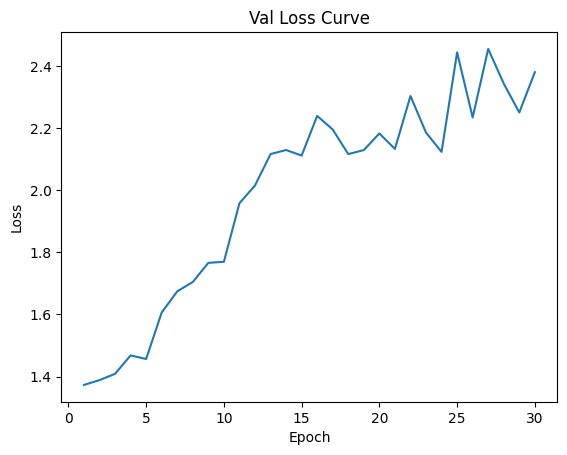

Finished Training Teacher
Teacher weights and architecture saved and exported for lambda: 0


In [27]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # Replace the last fully connected layer with a new one
    teacher_model.classifier = nn.Linear(1536, num_classes)
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=best_lr_teacher)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_teacher)

    # pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    # pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, 30, i, patience=patience_teacher)

    # Save the teacher model and its state
    torch.save(teacher_model.state_dict(), f'teacher_model_weights_rkd_wider_lambda{i}2.pth')
    torch.save(teacher_model, f'teacher_model_rkd_wider_lambda{i}2.pth')
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:00<00:00,  1.34it/s]


*******Epoch 0: loss - 1.621291775026439


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:01<00:00,  1.33it/s]


*******Epoch 1: loss - 1.5584075495048806


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:01<00:00,  1.34it/s]


*******Epoch 2: loss - 1.5093599535800792


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:06<00:00,  1.28it/s]


Average Pretrain Adversary epoch loss:  0.3652281685743803


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:06<00:00,  1.28it/s]


Average Pretrain Adversary epoch loss:  0.36532716664635106


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:06<00:00,  1.29it/s]


Average Pretrain Adversary epoch loss:  0.3655868629798477


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.22408904944672997


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 1/300*****
*****Train Loss:  4.806035 Val Loss:  4.505193*****
*****Validation Accuracy: 23.35%*****
*****Total Avg Disparity: 0.058127971856170496*****

Class Team_Sports: Recall Difference = 0.1062723284945507
Class Celebration: Recall Difference = -0.11866359447004599
Class Parade: Recall Difference = -0.07951126665438696
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = -0.06800152555301303
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.06110080395794681
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.0062499999999999995
Class Water Activities: Recall Difference = 0.05855547960811125
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.008130081300813007
Class Family: Recall Difference = -0.01666666666666

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.1732612102303976


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.75it/s]


*****Epoch 2/300*****
*****Train Loss:  4.629035 Val Loss:  4.255910*****
*****Validation Accuracy: 29.32%*****
*****Total Avg Disparity: 0.0474287178651308*****

Class Team_Sports: Recall Difference = 0.03823542712431616
Class Celebration: Recall Difference = -0.02419354838709678
Class Parade: Recall Difference = -0.01909498372935471
Class Waiter_Or_Waitress: Recall Difference = -0.06593406593406592
Class Individual_Sports: Recall Difference = -0.09862700228832955
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.05837971552257265
Class Business: Recall Difference = -0.03295068027210886
Class Dresses: Recall Difference = -0.10673076923076921
Class Water Activities: Recall Difference = -0.0566188197767144
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.005950884251110551
Class Family: Recall

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.16928526726953777


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 3/300*****
*****Train Loss:  4.532826 Val Loss:  4.150535*****
*****Validation Accuracy: 31.98%*****
*****Total Avg Disparity: 0.12032368847798873*****

Class Team_Sports: Recall Difference = 0.09311264866820412
Class Celebration: Recall Difference = -0.09216589861751151
Class Parade: Recall Difference = -0.07613434027138208
Class Waiter_Or_Waitress: Recall Difference = -0.10910518053375198
Class Individual_Sports: Recall Difference = -0.13466819221967963
Class Surgeons: Recall Difference = 0.02380952380952381
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.14471243042671617
Class Business: Recall Difference = -0.13860544217687074
Class Dresses: Recall Difference = -0.2336538461538461
Class Water Activities: Recall Difference = 0.14843928001822743
Class Picnic: Recall Difference = -0.18181818181818182
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.1129829

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.16585822628788005


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 4/300*****
*****Train Loss:  4.494120 Val Loss:  4.153438*****
*****Validation Accuracy: 31.83%*****
*****Total Avg Disparity: 0.08524617500342446*****

Class Team_Sports: Recall Difference = 0.10215710215710216
Class Celebration: Recall Difference = 0.008448540706605168
Class Parade: Recall Difference = -0.09037882974151162
Class Waiter_Or_Waitress: Recall Difference = -0.037676609105180545
Class Individual_Sports: Recall Difference = -0.13893974065598774
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.08163265306122448
Class Law_Enforcement: Recall Difference = 0.1804576376004947
Class Business: Recall Difference = -0.020833333333333332
Class Dresses: Recall Difference = -0.24375
Class Water Activities: Recall Difference = -0.032467532467532534
Class Picnic: Recall Difference = -0.05454545454545454
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.16514718817707932


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.66it/s]


*****Epoch 5/300*****
*****Train Loss:  4.419787 Val Loss:  4.122212*****
*****Validation Accuracy: 31.98%*****
*****Total Avg Disparity: 0.08178272654309933*****

Class Team_Sports: Recall Difference = 0.10832994166327503
Class Celebration: Recall Difference = -0.022273425499231947
Class Parade: Recall Difference = -0.11831522072818818
Class Waiter_Or_Waitress: Recall Difference = -0.05572998430141288
Class Individual_Sports: Recall Difference = -0.2030511060259345
Class Surgeons: Recall Difference = -0.03125
Class Spa: Recall Difference = -0.1836734693877551
Class Law_Enforcement: Recall Difference = -0.032776747062461364
Class Business: Recall Difference = -0.1698554421768707
Class Dresses: Recall Difference = -0.18124999999999997
Class Water Activities: Recall Difference = -0.03451811346548184
Class Picnic: Recall Difference = -0.05454545454545454
Class Rescue: Recall Difference = 0.012987012987012988
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Reca

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.16788667049488903


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 6/300*****
*****Train Loss:  4.389284 Val Loss:  4.051602*****
*****Validation Accuracy: 35.58%*****
*****Total Avg Disparity: 0.09929629719808175*****

Class Team_Sports: Recall Difference = 0.053995387328721
Class Celebration: Recall Difference = -0.07296466973886329
Class Parade: Recall Difference = -0.07177503530423046
Class Waiter_Or_Waitress: Recall Difference = -0.14678178963893254
Class Individual_Sports: Recall Difference = -0.10266971777269263
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.10204081632653061
Class Law_Enforcement: Recall Difference = 0.16042053184910332
Class Business: Recall Difference = -0.1294642857142857
Class Dresses: Recall Difference = -0.2668269230769231
Class Water Activities: Recall Difference = 0.10833902939166085
Class Picnic: Recall Difference = -0.03636363636363636
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.00754337

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.16543058471547234


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 7/300*****
*****Train Loss:  4.333983 Val Loss:  4.001238*****
*****Validation Accuracy: 36.74%*****
*****Total Avg Disparity: 0.12023249433588679*****

Class Team_Sports: Recall Difference = 0.12834079500746176
Class Celebration: Recall Difference = 0.0023041474654377503
Class Parade: Recall Difference = -0.11616626757536691
Class Waiter_Or_Waitress: Recall Difference = -0.1295133437990581
Class Individual_Sports: Recall Difference = -0.11651411136536993
Class Surgeons: Recall Difference = -0.03125
Class Spa: Recall Difference = -0.24489795918367346
Class Law_Enforcement: Recall Difference = 0.16895485466914045
Class Business: Recall Difference = -0.06547619047619047
Class Dresses: Recall Difference = -0.4480769230769231
Class Water Activities: Recall Difference = 0.018910913647755767
Class Picnic: Recall Difference = -0.09090909090909091
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.1632886097111084


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.69it/s]


*****Epoch 8/300*****
*****Train Loss:  4.273868 Val Loss:  3.948812*****
*****Validation Accuracy: 37.69%*****
*****Total Avg Disparity: 0.12005074934987378*****

Class Team_Sports: Recall Difference = 0.12472301361190252
Class Celebration: Recall Difference = -0.043394777265745005
Class Parade: Recall Difference = -0.08515994351323136
Class Waiter_Or_Waitress: Recall Difference = -0.11459968602825746
Class Individual_Sports: Recall Difference = -0.2851258581235699
Class Surgeons: Recall Difference = 0.0014880952380952328
Class Spa: Recall Difference = -0.22448979591836732
Class Law_Enforcement: Recall Difference = 0.06283240568954856
Class Business: Recall Difference = -0.03869047619047622
Class Dresses: Recall Difference = -0.28557692307692306
Class Water Activities: Recall Difference = 0.15402141717931195
Class Picnic: Recall Difference = -0.1272727272727273
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.02830188679245283
Class Performance_And_Entertain

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.16361981938466613


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 9/300*****
*****Train Loss:  4.237202 Val Loss:  3.853691*****
*****Validation Accuracy: 38.61%*****
*****Total Avg Disparity: 0.14764508795608486*****

Class Team_Sports: Recall Difference = 0.10353638131415899
Class Celebration: Recall Difference = 0.004992319508448556
Class Parade: Recall Difference = -0.18659053232639522
Class Waiter_Or_Waitress: Recall Difference = -0.11930926216640501
Class Individual_Sports: Recall Difference = -0.11045003813882537
Class Surgeons: Recall Difference = -0.014880952380952384
Class Spa: Recall Difference = -0.3469387755102041
Class Law_Enforcement: Recall Difference = 0.19406307977736553
Class Business: Recall Difference = -0.0580357142857143
Class Dresses: Recall Difference = -0.49182692307692316
Class Water Activities: Recall Difference = -0.011164274322168988
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.00512715340442986
Class Performance_And_Entertai

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.37it/s]


Average Adversary epoch loss: 0.1618741553414751


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.66it/s]


*****Epoch 10/300*****
*****Train Loss:  4.201175 Val Loss:  3.958882*****
*****Validation Accuracy: 37.60%*****
*****Total Avg Disparity: 0.11507739471609707*****

Class Team_Sports: Recall Difference = 0.13017229683896359
Class Celebration: Recall Difference = 0.018433179723502294
Class Parade: Recall Difference = -0.10677227236446235
Class Waiter_Or_Waitress: Recall Difference = -0.2032967032967033
Class Individual_Sports: Recall Difference = -0.18764302059496568
Class Surgeons: Recall Difference = 0.09077380952380948
Class Spa: Recall Difference = -0.44897959183673475
Class Law_Enforcement: Recall Difference = 0.10364873222016074
Class Business: Recall Difference = -0.02657312925170069
Class Dresses: Recall Difference = -0.1629807692307693
Class Water Activities: Recall Difference = 0.07917521075415818
Class Picnic: Recall Difference = -2.7755575615628914e-17
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.015176374077112385
Class Performance_And_Entert

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.37it/s]


Average Adversary epoch loss: 0.16223773029115465


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.69it/s]


*****Epoch 11/300*****
*****Train Loss:  4.130414 Val Loss:  3.893860*****
*****Validation Accuracy: 39.19%*****
*****Total Avg Disparity: 0.10375882593326037*****

Class Team_Sports: Recall Difference = 0.07798580020802237
Class Celebration: Recall Difference = -0.10829493087557604
Class Parade: Recall Difference = -0.21207097685270465
Class Waiter_Or_Waitress: Recall Difference = -0.1295133437990581
Class Individual_Sports: Recall Difference = -0.07364607170099169
Class Surgeons: Recall Difference = -0.08333333333333337
Class Spa: Recall Difference = -0.1836734693877551
Class Law_Enforcement: Recall Difference = 0.1533704390847248
Class Business: Recall Difference = -0.046768707482993166
Class Dresses: Recall Difference = -0.22307692307692306
Class Water Activities: Recall Difference = 0.12485759854180911
Class Picnic: Recall Difference = -2.7755575615628914e-17
Class Rescue: Recall Difference = -0.011988011988011985
Class Cheering: Recall Difference = 0.0
Class Performance_And_Enter

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.16248822653735126


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.65it/s]


*****Epoch 12/300*****
*****Train Loss:  4.089774 Val Loss:  3.807946*****
*****Validation Accuracy: 41.01%*****
*****Total Avg Disparity: 0.09162335898218617*****

Class Team_Sports: Recall Difference = 0.0780762447429113
Class Celebration: Recall Difference = -0.0026881720430107503
Class Parade: Recall Difference = -0.1112543746546325
Class Waiter_Or_Waitress: Recall Difference = -0.14678178963893249
Class Individual_Sports: Recall Difference = -0.06945080091533173
Class Surgeons: Recall Difference = -0.03869047619047619
Class Spa: Recall Difference = -0.22448979591836735
Class Law_Enforcement: Recall Difference = 0.07841682127396415
Class Business: Recall Difference = -0.06738945578231287
Class Dresses: Recall Difference = -0.3024038461538462
Class Water Activities: Recall Difference = 0.033264980633401664
Class Picnic: Recall Difference = -0.10909090909090909
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.02399507793273175
Class Performance_And_Entertai

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.16057230545966714


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 13/300*****
*****Train Loss:  4.067125 Val Loss:  3.816085*****
*****Validation Accuracy: 40.49%*****
*****Total Avg Disparity: 0.10779963575811399*****

Class Team_Sports: Recall Difference = 0.1013431013431012
Class Celebration: Recall Difference = -0.058755760368663645
Class Parade: Recall Difference = -0.16258365567630623
Class Waiter_Or_Waitress: Recall Difference = -0.15227629513343793
Class Individual_Sports: Recall Difference = -0.1420289855072464
Class Surgeons: Recall Difference = -0.053571428571428575
Class Spa: Recall Difference = -0.16326530612244897
Class Law_Enforcement: Recall Difference = 0.07161410018552877
Class Business: Recall Difference = -0.004251700680272086
Class Dresses: Recall Difference = -0.44375000000000003
Class Water Activities: Recall Difference = 0.017999544315333904
Class Picnic: Recall Difference = -0.2
Class Rescue: Recall Difference = 0.019730269730269725
Class Cheering: Recall Difference = 0.036300246103363416
Class Performance_And_Ente

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.16038396085302034


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.63it/s]


*****Epoch 14/300*****
*****Train Loss:  4.003343 Val Loss:  3.795034*****
*****Validation Accuracy: 42.34%*****
*****Total Avg Disparity: 0.12567017653250265*****

Class Team_Sports: Recall Difference = 0.12944874055985167
Class Celebration: Recall Difference = 0.018049155145929252
Class Parade: Recall Difference = -0.14379566525449755
Class Waiter_Or_Waitress: Recall Difference = -0.20015698587127162
Class Individual_Sports: Recall Difference = -0.10804729214340203
Class Surgeons: Recall Difference = -0.035714285714285726
Class Spa: Recall Difference = -0.36734693877551017
Class Law_Enforcement: Recall Difference = 0.0649350649350649
Class Business: Recall Difference = -0.07929421768707479
Class Dresses: Recall Difference = -0.3504807692307692
Class Water Activities: Recall Difference = 0.01834130781499199
Class Picnic: Recall Difference = -0.43636363636363634
Class Rescue: Recall Difference = 0.007242757242757247
Class Cheering: Recall Difference = -0.0014356029532403593
Class Perfo

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.16045642874123137


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.67it/s]


*****Epoch 15/300*****
*****Train Loss:  4.008700 Val Loss:  3.749980*****
*****Validation Accuracy: 42.83%*****
*****Total Avg Disparity: 0.12505969935179925*****

Class Team_Sports: Recall Difference = 0.12332112332112333
Class Celebration: Recall Difference = -0.028033794162826475
Class Parade: Recall Difference = -0.1197887886044085
Class Waiter_Or_Waitress: Recall Difference = -0.15934065934065939
Class Individual_Sports: Recall Difference = -0.0596109839816934
Class Surgeons: Recall Difference = 0.016369047619047623
Class Spa: Recall Difference = -0.30612244897959184
Class Law_Enforcement: Recall Difference = 0.16932591218305504
Class Business: Recall Difference = -0.006802721088435382
Class Dresses: Recall Difference = -0.43990384615384615
Class Water Activities: Recall Difference = 0.018796992481203034
Class Picnic: Recall Difference = -0.32727272727272727
Class Rescue: Recall Difference = 0.07167832167832168
Class Cheering: Recall Difference = 0.011689909762100083
Class Perfor

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.16141247358403088


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.71it/s]


*****Epoch 16/300*****
*****Train Loss:  3.946575 Val Loss:  3.788250*****
*****Validation Accuracy: 43.29%*****
*****Total Avg Disparity: 0.1250762193224361*****

Class Team_Sports: Recall Difference = 0.060190837968615796
Class Celebration: Recall Difference = 0.058755760368663534
Class Parade: Recall Difference = -0.12641984404739992
Class Waiter_Or_Waitress: Recall Difference = -0.218210361067504
Class Individual_Sports: Recall Difference = -0.16102212051868808
Class Surgeons: Recall Difference = -0.09077380952380953
Class Spa: Recall Difference = -0.3673469387755102
Class Law_Enforcement: Recall Difference = 0.18750773036487323
Class Business: Recall Difference = -0.01615646258503395
Class Dresses: Recall Difference = -0.4149038461538461
Class Water Activities: Recall Difference = -0.01891091364775571
Class Picnic: Recall Difference = -0.1272727272727273
Class Rescue: Recall Difference = 0.007242757242757254
Class Cheering: Recall Difference = -0.024610336341263323
Class Performan

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:59<00:00,  1.36it/s]


Average Adversary epoch loss: 0.16174397452010048


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.66it/s]


*****Epoch 17/300*****
*****Train Loss:  3.898880 Val Loss:  3.737777*****
*****Validation Accuracy: 43.67%*****
*****Total Avg Disparity: 0.1345353722065131*****

Class Team_Sports: Recall Difference = 0.07387057387057383
Class Celebration: Recall Difference = 0.01920122887864817
Class Parade: Recall Difference = -0.12494627617117954
Class Waiter_Or_Waitress: Recall Difference = -0.2362637362637363
Class Individual_Sports: Recall Difference = -0.08981693363844395
Class Surgeons: Recall Difference = 0.008928571428571425
Class Spa: Recall Difference = -0.30612244897959184
Class Law_Enforcement: Recall Difference = 0.07161410018552877
Class Business: Recall Difference = -0.09800170068027203
Class Dresses: Recall Difference = -0.541826923076923
Class Water Activities: Recall Difference = -0.004101161995898828
Class Picnic: Recall Difference = -0.1818181818181819
Class Rescue: Recall Difference = 0.09765234765234766
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainmen

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.16148672551836496


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 18/300*****
*****Train Loss:  3.847385 Val Loss:  3.743566*****
*****Validation Accuracy: 43.32%*****
*****Total Avg Disparity: 0.16367178104778407*****

Class Team_Sports: Recall Difference = 0.12612490390268172
Class Celebration: Recall Difference = -0.06221198156682034
Class Parade: Recall Difference = -0.1425676920243139
Class Waiter_Or_Waitress: Recall Difference = -0.19073783359497648
Class Individual_Sports: Recall Difference = -0.052250190694126675
Class Surgeons: Recall Difference = -0.09970238095238096
Class Spa: Recall Difference = 0.4693877551020408
Class Law_Enforcement: Recall Difference = 0.0944959802102659
Class Business: Recall Difference = -0.049957482993197244
Class Dresses: Recall Difference = -0.5605769230769231
Class Water Activities: Recall Difference = 0.05616313511050364
Class Picnic: Recall Difference = -0.5636363636363636
Class Rescue: Recall Difference = 0.05244755244755245
Class Cheering: Recall Difference = 0.02768662838392126
Class Performance_

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.37it/s]


Average Adversary epoch loss: 0.16075484776570473


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.66it/s]


*****Epoch 19/300*****
*****Train Loss:  3.809835 Val Loss:  3.770992*****
*****Validation Accuracy: 42.91%*****
*****Total Avg Disparity: 0.1547914896884394*****

Class Team_Sports: Recall Difference = 0.1186406186406187
Class Celebration: Recall Difference = 0.06105990783410142
Class Parade: Recall Difference = -0.22969239270583902
Class Waiter_Or_Waitress: Recall Difference = -0.18053375196232335
Class Individual_Sports: Recall Difference = -0.052593440122044255
Class Surgeons: Recall Difference = -0.17559523809523808
Class Spa: Recall Difference = -0.40816326530612246
Class Law_Enforcement: Recall Difference = 0.253308596165739
Class Business: Recall Difference = -0.02784863945578231
Class Dresses: Recall Difference = -0.4586538461538462
Class Water Activities: Recall Difference = -0.011392116655274509
Class Picnic: Recall Difference = -0.20000000000000004
Class Rescue: Recall Difference = 0.006743256743256744
Class Cheering: Recall Difference = 0.05086136177194423
Class Performanc

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.37it/s]


Average Adversary epoch loss: 0.1601293935543961


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.67it/s]


*****Epoch 20/300*****
*****Train Loss:  3.786990 Val Loss:  3.659295*****
*****Validation Accuracy: 45.95%*****
*****Total Avg Disparity: 0.1363880954706933*****

Class Team_Sports: Recall Difference = 0.05254827477049706
Class Celebration: Recall Difference = -0.14823348694316438
Class Parade: Recall Difference = -0.08178301713022651
Class Waiter_Or_Waitress: Recall Difference = -0.25667189952904246
Class Individual_Sports: Recall Difference = -0.14168573607932877
Class Surgeons: Recall Difference = -0.13690476190476192
Class Spa: Recall Difference = -0.2653061224489796
Class Law_Enforcement: Recall Difference = 0.08299319727891158
Class Business: Recall Difference = 0.0046768707482993666
Class Dresses: Recall Difference = -0.5293269230769231
Class Water Activities: Recall Difference = 0.04761904761904745
Class Picnic: Recall Difference = -0.18181818181818185
Class Rescue: Recall Difference = -0.031218781218781216
Class Cheering: Recall Difference = 0.030557834290401965
Class Perform

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.36it/s]


Average Adversary epoch loss: 0.1594682088420715


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.66it/s]


*****Epoch 21/300*****
*****Train Loss:  3.738577 Val Loss:  3.760594*****
*****Validation Accuracy: 44.07%*****
*****Total Avg Disparity: 0.11520341171131669*****

Class Team_Sports: Recall Difference = 0.09315787093564876
Class Celebration: Recall Difference = -0.04416282642089098
Class Parade: Recall Difference = -0.14588321974580953
Class Waiter_Or_Waitress: Recall Difference = -0.1412872841444271
Class Individual_Sports: Recall Difference = -0.17223493516399696
Class Surgeons: Recall Difference = -0.004464285714285726
Class Spa: Recall Difference = -0.14285714285714285
Class Law_Enforcement: Recall Difference = 0.16932591218305504
Class Business: Recall Difference = -0.05782312925170063
Class Dresses: Recall Difference = -0.5812499999999999
Class Water Activities: Recall Difference = 0.048074732285258714
Class Picnic: Recall Difference = -0.1272727272727273
Class Rescue: Recall Difference = 0.007742257742257744
Class Cheering: Recall Difference = 0.009433962264150943
Class Perform

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.15633230385037117


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.66it/s]


*****Epoch 22/300*****
*****Train Loss:  3.709048 Val Loss:  3.791944*****
*****Validation Accuracy: 44.07%*****
*****Total Avg Disparity: 0.13767380294755385*****

Class Team_Sports: Recall Difference = 0.022995522995522988
Class Celebration: Recall Difference = -0.1347926267281106
Class Parade: Recall Difference = -0.15411064038803957
Class Waiter_Or_Waitress: Recall Difference = -0.27001569858712715
Class Individual_Sports: Recall Difference = -0.05369946605644549
Class Surgeons: Recall Difference = 0.0654761904761905
Class Spa: Recall Difference = -0.30612244897959184
Class Law_Enforcement: Recall Difference = 0.08719851576994431
Class Business: Recall Difference = -0.10012755102040816
Class Dresses: Recall Difference = -0.43750000000000006
Class Water Activities: Recall Difference = -0.04226475279106856
Class Picnic: Recall Difference = -0.32727272727272727
Class Rescue: Recall Difference = 0.09240759240759244
Class Cheering: Recall Difference = -0.006357670221493042
Class Perform

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.1606681928222562


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.74it/s]


*****Epoch 23/300*****
*****Train Loss:  3.656075 Val Loss:  3.777095*****
*****Validation Accuracy: 46.58%*****
*****Total Avg Disparity: 0.15177094315833933*****

Class Team_Sports: Recall Difference = 0.08207841541174876
Class Celebration: Recall Difference = -0.006528417818740362
Class Parade: Recall Difference = -0.13556824461226746
Class Waiter_Or_Waitress: Recall Difference = -0.10518053375196235
Class Individual_Sports: Recall Difference = -0.07227307398932115
Class Surgeons: Recall Difference = -0.016369047619047616
Class Spa: Recall Difference = -0.4693877551020408
Class Law_Enforcement: Recall Difference = 0.18268398268398273
Class Business: Recall Difference = -0.005527210884353706
Class Dresses: Recall Difference = -0.5918269230769231
Class Water Activities: Recall Difference = 0.07142857142857151
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = 0.07842157842157843
Class Cheering: Recall Difference = 0.029122231337161616
Class Perfor

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.40it/s]


Average Adversary epoch loss: 0.15848774591713777


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 24/300*****
*****Train Loss:  3.638991 Val Loss:  3.741212*****
*****Validation Accuracy: 45.86%*****
*****Total Avg Disparity: 0.15244009618878723*****

Class Team_Sports: Recall Difference = 0.0902862569529237
Class Celebration: Recall Difference = -0.07258064516129031
Class Parade: Recall Difference = -0.13188432492171676
Class Waiter_Or_Waitress: Recall Difference = -0.2158555729984301
Class Individual_Sports: Recall Difference = -0.09042715484363084
Class Surgeons: Recall Difference = -0.07142857142857145
Class Spa: Recall Difference = -0.28571428571428564
Class Law_Enforcement: Recall Difference = 0.15572047000618433
Class Business: Recall Difference = 0.024234693877551117
Class Dresses: Recall Difference = -0.5605769230769231
Class Water Activities: Recall Difference = -0.005126452494873535
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = 0.09815184815184816
Class Cheering: Recall Difference = 0.06316652994257588
Class Performan

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.159045104811221


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.71it/s]


*****Epoch 25/300*****
*****Train Loss:  3.569048 Val Loss:  3.697161*****
*****Validation Accuracy: 46.18%*****
*****Total Avg Disparity: 0.15129578364915305*****

Class Team_Sports: Recall Difference = 0.09037670148781252
Class Celebration: Recall Difference = -0.049923195084485394
Class Parade: Recall Difference = -0.12070976852704612
Class Waiter_Or_Waitress: Recall Difference = -0.3383045525902669
Class Individual_Sports: Recall Difference = -0.13859649122807016
Class Surgeons: Recall Difference = -0.047619047619047616
Class Spa: Recall Difference = -0.4081632653061224
Class Law_Enforcement: Recall Difference = 0.03982683982683982
Class Business: Recall Difference = -0.015518707482993221
Class Dresses: Recall Difference = -0.5480769230769231
Class Water Activities: Recall Difference = 0.011050353155616421
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = 0.07217782217782219
Class Cheering: Recall Difference = 0.027686628383921247
Class Perfor

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.15982725848386317


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 26/300*****
*****Train Loss:  3.540557 Val Loss:  3.704585*****
*****Validation Accuracy: 46.49%*****
*****Total Avg Disparity: 0.1368691673770704*****

Class Team_Sports: Recall Difference = 0.06423823090489766
Class Celebration: Recall Difference = -0.042242703533026116
Class Parade: Recall Difference = -0.14588321974580953
Class Waiter_Or_Waitress: Recall Difference = -0.17974882260596553
Class Individual_Sports: Recall Difference = -0.1606788710907704
Class Surgeons: Recall Difference = 0.037202380952380876
Class Spa: Recall Difference = -0.32653061224489793
Class Law_Enforcement: Recall Difference = 0.042300556586270854
Class Business: Recall Difference = -0.07929421768707479
Class Dresses: Recall Difference = -0.4899038461538462
Class Water Activities: Recall Difference = 0.10059239006607446
Class Picnic: Recall Difference = -0.18181818181818185
Class Rescue: Recall Difference = 0.1048951048951049
Class Cheering: Recall Difference = 0.023379819524200166
Class Performan

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.15968853506593056


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.72it/s]


*****Epoch 27/300*****
*****Train Loss:  3.501261 Val Loss:  3.673465*****
*****Validation Accuracy: 46.18%*****
*****Total Avg Disparity: 0.1292403407974282*****

Class Team_Sports: Recall Difference = 0.05876633654411434
Class Celebration: Recall Difference = -0.009216589861751168
Class Parade: Recall Difference = -0.20599250936329594
Class Waiter_Or_Waitress: Recall Difference = -0.14128728414442704
Class Individual_Sports: Recall Difference = -0.14134248665141108
Class Surgeons: Recall Difference = 0.01339285714285704
Class Spa: Recall Difference = -0.36734693877551017
Class Law_Enforcement: Recall Difference = 0.11910946196660493
Class Business: Recall Difference = -0.036777210884353706
Class Dresses: Recall Difference = -0.55
Class Water Activities: Recall Difference = 0.0035315561631352743
Class Picnic: Recall Difference = -0.3272727272727274
Class Rescue: Recall Difference = 0.02022977022977023
Class Cheering: Recall Difference = 0.058244462674323205
Class Performance_And_Enter

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.1579482449149644


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 28/300*****
*****Train Loss:  3.466317 Val Loss:  3.755467*****
*****Validation Accuracy: 45.89%*****
*****Total Avg Disparity: 0.1461920233689013*****

Class Team_Sports: Recall Difference = 0.10964138741916507
Class Celebration: Recall Difference = -0.04953917050691248
Class Parade: Recall Difference = -0.05753054583410083
Class Waiter_Or_Waitress: Recall Difference = -0.11538461538461536
Class Individual_Sports: Recall Difference = -0.04420289855072462
Class Surgeons: Recall Difference = -0.08630952380952384
Class Spa: Recall Difference = -0.44897959183673475
Class Law_Enforcement: Recall Difference = 0.10773036487322202
Class Business: Recall Difference = -0.048044217687074786
Class Dresses: Recall Difference = -0.5067307692307694
Class Water Activities: Recall Difference = 0.048872180451127956
Class Picnic: Recall Difference = -0.2909090909090909
Class Rescue: Recall Difference = 0.03271728271728272
Class Cheering: Recall Difference = 0.0705496308449549
Class Performanc

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.1601885092663176


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.72it/s]


*****Epoch 29/300*****
*****Train Loss:  3.406316 Val Loss:  3.787274*****
*****Validation Accuracy: 46.35%*****
*****Total Avg Disparity: 0.15665198495863997*****

Class Team_Sports: Recall Difference = 0.08481436259214037
Class Celebration: Recall Difference = 0.055299539170506895
Class Parade: Recall Difference = -0.1373488057960337
Class Waiter_Or_Waitress: Recall Difference = -0.13893249607535324
Class Individual_Sports: Recall Difference = -0.10240274599542332
Class Surgeons: Recall Difference = -0.03273809523809529
Class Spa: Recall Difference = -0.44897959183673475
Class Law_Enforcement: Recall Difference = 0.14681508967223256
Class Business: Recall Difference = -0.10948129251700683
Class Dresses: Recall Difference = -0.55
Class Water Activities: Recall Difference = 0.06390977443609025
Class Picnic: Recall Difference = -0.34545454545454546
Class Rescue: Recall Difference = 0.046703296703296704
Class Cheering: Recall Difference = 0.09372436423297785
Class Performance_And_Enterta

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.40it/s]


Average Adversary epoch loss: 0.16238945138491231


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 30/300*****
*****Train Loss:  3.367381 Val Loss:  3.854152*****
*****Validation Accuracy: 46.00%*****
*****Total Avg Disparity: 0.12052451849055533*****

Class Team_Sports: Recall Difference = 0.11775878442545085
Class Celebration: Recall Difference = -0.020737327188940058
Class Parade: Recall Difference = -0.04420703628660899
Class Waiter_Or_Waitress: Recall Difference = -0.05180533751962324
Class Individual_Sports: Recall Difference = -0.05789473684210539
Class Surgeons: Recall Difference = 0.005952380952380931
Class Spa: Recall Difference = -0.22448979591836735
Class Law_Enforcement: Recall Difference = 0.12838589981447113
Class Business: Recall Difference = -0.0686649659863946
Class Dresses: Recall Difference = -0.5874999999999999
Class Water Activities: Recall Difference = 0.06413761676919588
Class Picnic: Recall Difference = -0.25454545454545463
Class Rescue: Recall Difference = 0.03421578421578422
Class Cheering: Recall Difference = 0.06398687448728463
Class Performan

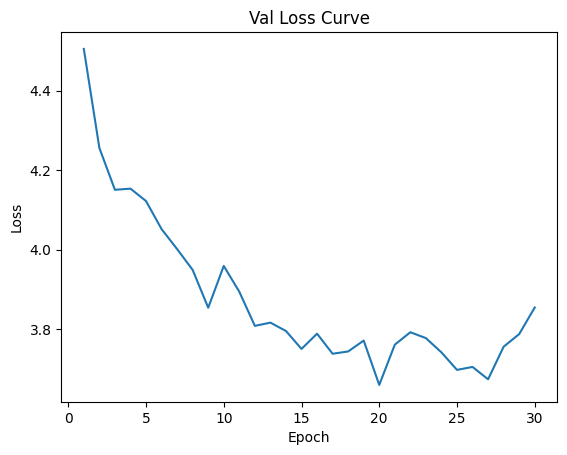

Student weights and architecture saved and exported for lambda: 0


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:03<00:00,  1.31it/s]


*******Epoch 0: loss - 1.642734698307367


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:03<00:00,  1.31it/s]


*******Epoch 1: loss - 1.5633701836621319


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:01<00:00,  1.34it/s]


*******Epoch 2: loss - 1.5285287366973028


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:07<00:00,  1.27it/s]


Average Pretrain Adversary epoch loss:  0.3646955972100482


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:06<00:00,  1.28it/s]


Average Pretrain Adversary epoch loss:  0.3644094744950165


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:05<00:00,  1.29it/s]


Average Pretrain Adversary epoch loss:  0.3651148071627558


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.37it/s]


Average Adversary epoch loss: 0.2484772108771183


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 1/300*****
*****Train Loss:  15.564145 Val Loss:  16.258784*****
*****Validation Accuracy: 24.24%*****
*****Total Avg Disparity: 0.046597910983283586*****

Class Team_Sports: Recall Difference = 0.005019671686338212
Class Celebration: Recall Difference = -0.009216589861751154
Class Parade: Recall Difference = -0.04119850187265922
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.1141113653699466
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.08794063079777367
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water Activities: Recall Difference = 0.022100706311232635
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has been appended to ./runs_2023_12_04_11

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:54<00:00,  1.41it/s]


Average Adversary epoch loss: 0.1854337577558594


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.74it/s]


*****Epoch 2/300*****
*****Train Loss:  30.948105 Val Loss:  33.577273*****
*****Validation Accuracy: 26.49%*****
*****Total Avg Disparity: 0.07721875259073045*****

Class Team_Sports: Recall Difference = 0.07059195948084829
Class Celebration: Recall Difference = -0.03801843317972349
Class Parade: Recall Difference = -0.07699392153251072
Class Waiter_Or_Waitress: Recall Difference = 0.03375196232339091
Class Individual_Sports: Recall Difference = -0.15896262395118232
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.10859616573902288
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.07307692307692307
Class Water Activities: Recall Difference = 0.05775803144224195
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has been a

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.1709694155940303


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 3/300*****
*****Train Loss:  30.965706 Val Loss:  30.751165*****
*****Validation Accuracy: 28.83%*****
*****Total Avg Disparity: 0.0720241873025286*****

Class Team_Sports: Recall Difference = 0.04031565142676252
Class Celebration: Recall Difference = -0.06067588325652842
Class Parade: Recall Difference = -0.15257567385031
Class Waiter_Or_Waitress: Recall Difference = -0.045525902668759805
Class Individual_Sports: Recall Difference = -0.1421052631578948
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.133704390847248
Class Business: Recall Difference = 0.01020408163265306
Class Dresses: Recall Difference = 0.008173076923076922
Class Water Activities: Recall Difference = 0.1181362497151971
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.060849886849383986
Class Family: Recall Diffe

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.17101123791050027


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.71it/s]


*****Epoch 4/300*****
*****Train Loss:  29.830728 Val Loss:  34.916403*****
*****Validation Accuracy: 29.32%*****
*****Total Avg Disparity: 0.09478044463120806*****

Class Team_Sports: Recall Difference = 0.061457061457061424
Class Celebration: Recall Difference = 0.003456221198156681
Class Parade: Recall Difference = -0.13501565665868487
Class Waiter_Or_Waitress: Recall Difference = -0.030612244897959183
Class Individual_Sports: Recall Difference = -0.20366132723112126
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.24007421150278288
Class Business: Recall Difference = -0.0537840136054422
Class Dresses: Recall Difference = -0.07788461538461533
Class Water Activities: Recall Difference = 0.10925039872408299
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.03260869565217391
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Rec

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.16751560766571832


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 5/300*****
*****Train Loss:  30.220889 Val Loss:  31.637362*****
*****Validation Accuracy: 31.54%*****
*****Total Avg Disparity: 0.12164849873828228*****

Class Team_Sports: Recall Difference = 0.06441911997467542
Class Celebration: Recall Difference = -0.04147465437788017
Class Parade: Recall Difference = -0.17928409160680303
Class Waiter_Or_Waitress: Recall Difference = -0.06043956043956045
Class Individual_Sports: Recall Difference = -0.2939359267734554
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.08101422387136675
Class Business: Recall Difference = -0.0939625850340136
Class Dresses: Recall Difference = -0.22500000000000003
Class Water Activities: Recall Difference = 0.14035087719298256
Class Picnic: Recall Difference = 0.14545454545454545
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.1211130668007711
Class 

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.16911638344143642


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 6/300*****
*****Train Loss:  29.850314 Val Loss:  32.555132*****
*****Validation Accuracy: 33.16%*****
*****Total Avg Disparity: 0.08312061254013021*****

Class Team_Sports: Recall Difference = 0.09324831547053769
Class Celebration: Recall Difference = 0.012672811059907807
Class Parade: Recall Difference = -0.10885982685577456
Class Waiter_Or_Waitress: Recall Difference = -0.1326530612244898
Class Individual_Sports: Recall Difference = -0.13363844393592678
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.16239950525664804
Class Business: Recall Difference = -0.0542091836734694
Class Dresses: Recall Difference = -0.1322115384615385
Class Water Activities: Recall Difference = 0.03451811346548189
Class Picnic: Recall Difference = -0.07272727272727272
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.010309278350515462
Clas

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.41it/s]


Average Adversary epoch loss: 0.16764559311631286


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.69it/s]


*****Epoch 7/300*****
*****Train Loss:  30.161843 Val Loss:  33.369479*****
*****Validation Accuracy: 33.65%*****
*****Total Avg Disparity: 0.12121967758275475*****

Class Team_Sports: Recall Difference = 0.08908786686564474
Class Celebration: Recall Difference = -0.03379416282642088
Class Parade: Recall Difference = -0.12795481058512947
Class Waiter_Or_Waitress: Recall Difference = -0.10439560439560439
Class Individual_Sports: Recall Difference = -0.21502669717772688
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.1836734693877551
Class Law_Enforcement: Recall Difference = 0.1173778602350031
Class Business: Recall Difference = -0.09757653061224489
Class Dresses: Recall Difference = -0.2793269230769231
Class Water Activities: Recall Difference = 0.14832535885167464
Class Picnic: Recall Difference = -0.16363636363636366
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.002346

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.16649057504571516


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.75it/s]


*****Epoch 8/300*****
*****Train Loss:  30.106131 Val Loss:  32.437955*****
*****Validation Accuracy: 35.18%*****
*****Total Avg Disparity: 0.09972880582343352*****

Class Team_Sports: Recall Difference = 0.09327092660425995
Class Celebration: Recall Difference = -0.08102918586789554
Class Parade: Recall Difference = -0.11978878860440845
Class Waiter_Or_Waitress: Recall Difference = -0.09654631083202511
Class Individual_Sports: Recall Difference = -0.15324180015255529
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14285714285714285
Class Law_Enforcement: Recall Difference = 0.18503401360544214
Class Business: Recall Difference = -0.05973639455782309
Class Dresses: Recall Difference = -0.33990384615384617
Class Water Activities: Recall Difference = 0.06413761676919588
Class Picnic: Recall Difference = -0.1090909090909091
Class Rescue: Recall Difference = 0.025974025974025976
Class Cheering: Recall Difference = -0.0028712059064807186
Class Performance_And_Enter

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.16619452976702173


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 9/300*****
*****Train Loss:  30.709267 Val Loss:  33.783244*****
*****Validation Accuracy: 34.49%*****
*****Total Avg Disparity: 0.11131988956883469*****

Class Team_Sports: Recall Difference = 0.07866413421968976
Class Celebration: Recall Difference = 0.06029185867895545
Class Parade: Recall Difference = -0.08153742248418983
Class Waiter_Or_Waitress: Recall Difference = -0.08634222919937204
Class Individual_Sports: Recall Difference = -0.2851258581235699
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.08163265306122448
Class Law_Enforcement: Recall Difference = 0.14693877551020412
Class Business: Recall Difference = -0.09800170068027209
Class Dresses: Recall Difference = -0.24807692307692308
Class Water Activities: Recall Difference = 0.10822510822510811
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.029335344899840757
Cla

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.16316232867079017


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.74it/s]


*****Epoch 10/300*****
*****Train Loss:  30.183160 Val Loss:  35.378042*****
*****Validation Accuracy: 35.84%*****
*****Total Avg Disparity: 0.11773137757537043*****

Class Team_Sports: Recall Difference = 0.05731922398589062
Class Celebration: Recall Difference = -0.01766513056835642
Class Parade: Recall Difference = -0.0651439798612391
Class Waiter_Or_Waitress: Recall Difference = -0.11930926216640501
Class Individual_Sports: Recall Difference = -0.25594965675057213
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.10204081632653061
Class Law_Enforcement: Recall Difference = 0.2055658627087199
Class Business: Recall Difference = -0.12882653061224494
Class Dresses: Recall Difference = -0.30432692307692305
Class Water Activities: Recall Difference = 0.06356801093643194
Class Picnic: Recall Difference = -0.16363636363636364
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0271

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.41it/s]


Average Adversary epoch loss: 0.16290055518900906


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.67it/s]


*****Epoch 11/300*****
*****Train Loss:  29.791242 Val Loss:  33.632594*****
*****Validation Accuracy: 37.26%*****
*****Total Avg Disparity: 0.13948775078361433*****

Class Team_Sports: Recall Difference = 0.07730746619635498
Class Celebration: Recall Difference = -0.012672811059907835
Class Parade: Recall Difference = -0.14803217289863085
Class Waiter_Or_Waitress: Recall Difference = -0.11145996860282575
Class Individual_Sports: Recall Difference = -0.2051106025934401
Class Surgeons: Recall Difference = 0.016369047619047616
Class Spa: Recall Difference = -0.12244897959183673
Class Law_Enforcement: Recall Difference = 0.23277674706246132
Class Business: Recall Difference = -0.06653911564625845
Class Dresses: Recall Difference = -0.44615384615384623
Class Water Activities: Recall Difference = 0.19229892914103452
Class Picnic: Recall Difference = -0.2909090909090909
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.00799835931091058
Class Performance_And_Enterta

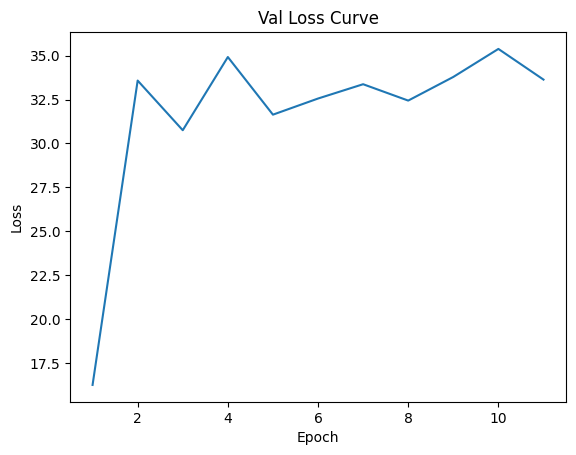

Student weights and architecture saved and exported for lambda: 3


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:02<00:00,  1.32it/s]


*******Epoch 0: loss - 1.6390774537015844


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:01<00:00,  1.34it/s]


*******Epoch 1: loss - 1.5614671846966686


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:01<00:00,  1.33it/s]


*******Epoch 2: loss - 1.5082878992881303


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:06<00:00,  1.28it/s]


Average Pretrain Adversary epoch loss:  0.3906441971107765


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:05<00:00,  1.29it/s]


Average Pretrain Adversary epoch loss:  0.39091906871324705


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:06<00:00,  1.28it/s]


Average Pretrain Adversary epoch loss:  0.39224681690519236


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.41it/s]


Average Adversary epoch loss: 0.26462060847768076


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 1/300*****
*****Train Loss:  12.618625 Val Loss:  12.728767*****
*****Validation Accuracy: 24.36%*****
*****Total Avg Disparity: 0.03927304994271757*****

Class Team_Sports: Recall Difference = 0.09238909238909243
Class Celebration: Recall Difference = -0.06797235023041476
Class Parade: Recall Difference = -0.04672438140848528
Class Waiter_Or_Waitress: Recall Difference = -0.01020408163265306
Class Individual_Sports: Recall Difference = 0.0399313501144164
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.02040816326530612
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.06634615384615386
Class Water Activities: Recall Difference = -0.016632490316700776
Class Picnic: Recall Difference = -0.03636363636363636
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.020031849803034112
Class Family: Reca

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.31732281058290857


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.75it/s]


*****Epoch 2/300*****
*****Train Loss:  26.527443 Val Loss:  33.419726*****
*****Validation Accuracy: 26.44%*****
*****Total Avg Disparity: 0.0972158389560436*****

Class Team_Sports: Recall Difference = 0.06559489892823234
Class Celebration: Recall Difference = -0.14247311827956982
Class Parade: Recall Difference = -0.13077914901455154
Class Waiter_Or_Waitress: Recall Difference = -0.11459968602825743
Class Individual_Sports: Recall Difference = -0.16010678871090775
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.04984539270253555
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water Activities: Recall Difference = 0.06390977443609014
Class Picnic: Recall Difference = -0.14545454545454545
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0021791970497024547
Class Family: Recall Difference = 0

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.37it/s]


Average Adversary epoch loss: 0.17793130653875847


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 3/300*****
*****Train Loss:  29.133639 Val Loss:  32.927546*****
*****Validation Accuracy: 29.21%*****
*****Total Avg Disparity: 0.0891930877249598*****

Class Team_Sports: Recall Difference = 0.11599511599511603
Class Celebration: Recall Difference = -0.09408602150537637
Class Parade: Recall Difference = -0.12549886412476208
Class Waiter_Or_Waitress: Recall Difference = -0.11459968602825746
Class Individual_Sports: Recall Difference = -0.1539282990083906
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.09907235621521332
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.10625000000000001
Class Water Activities: Recall Difference = -0.02551834130781494
Class Picnic: Recall Difference = -0.03636363636363637
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.020618556701030927
Class Family: Recal

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.17321950519158516


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 4/300*****
*****Train Loss:  28.909923 Val Loss:  31.559693*****
*****Validation Accuracy: 29.90%*****
*****Total Avg Disparity: 0.09096765076108539*****

Class Team_Sports: Recall Difference = 0.12899651788540673
Class Celebration: Recall Difference = 0.04070660522273428
Class Parade: Recall Difference = -0.04334745502548046
Class Waiter_Or_Waitress: Recall Difference = -0.1326530612244898
Class Individual_Sports: Recall Difference = -0.25003813882532416
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.1287569573283859
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.04134615384615385
Class Water Activities: Recall Difference = 0.13089542036910462
Class Picnic: Recall Difference = -0.05454545454545455
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.004358394099404913
Class Family: Recall D

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.16862819035664017


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.71it/s]


*****Epoch 5/300*****
*****Train Loss:  29.682486 Val Loss:  34.692722*****
*****Validation Accuracy: 31.54%*****
*****Total Avg Disparity: 0.10788634207934326*****

Class Team_Sports: Recall Difference = 0.05196038529371849
Class Celebration: Recall Difference = -0.0076804915514592995
Class Parade: Recall Difference = -0.11407871308405473
Class Waiter_Or_Waitress: Recall Difference = -0.1295133437990581
Class Individual_Sports: Recall Difference = -0.17036613272311218
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.2785405071119357
Class Business: Recall Difference = -0.08439625850340135
Class Dresses: Recall Difference = -0.09471153846153846
Class Water Activities: Recall Difference = 0.003987240829346206
Class Picnic: Recall Difference = -0.21818181818181823
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Rec

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.16909856146868366


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 6/300*****
*****Train Loss:  29.979426 Val Loss:  34.636866*****
*****Validation Accuracy: 33.71%*****
*****Total Avg Disparity: 0.10108990080885426*****

Class Team_Sports: Recall Difference = 0.13030796364129704
Class Celebration: Recall Difference = 0.016513056835637474
Class Parade: Recall Difference = -0.1085528335482287
Class Waiter_Or_Waitress: Recall Difference = -0.11616954474097332
Class Individual_Sports: Recall Difference = -0.22616323417238748
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.15819418676561528
Class Business: Recall Difference = -0.07908163265306123
Class Dresses: Recall Difference = -0.07932692307692309
Class Water Activities: Recall Difference = 0.06356801093643194
Class Picnic: Recall Difference = -0.14545454545454545
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.08641354454781663
Cla

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.16826966294535883


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 7/300*****
*****Train Loss:  29.630613 Val Loss:  32.987379*****
*****Validation Accuracy: 34.23%*****
*****Total Avg Disparity: 0.09392229126942671*****

Class Team_Sports: Recall Difference = 0.1062271062271063
Class Celebration: Recall Difference = 0.0875576036866359
Class Parade: Recall Difference = -0.08430036225210297
Class Waiter_Or_Waitress: Recall Difference = -0.13736263736263737
Class Individual_Sports: Recall Difference = -0.12971014492753624
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.07173778602350034
Class Business: Recall Difference = -0.011479591836734693
Class Dresses: Recall Difference = -0.01298076923076924
Class Water Activities: Recall Difference = 0.025974025974025983
Class Picnic: Recall Difference = -0.38181818181818183
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.07291928589388985
Cla

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.16771672500504387


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 8/300*****
*****Train Loss:  29.221198 Val Loss:  34.166057*****
*****Validation Accuracy: 36.59%*****
*****Total Avg Disparity: 0.14512555359879187*****

Class Team_Sports: Recall Difference = 0.13996291774069547
Class Celebration: Recall Difference = -0.08371735791090629
Class Parade: Recall Difference = -0.10554429913427893
Class Waiter_Or_Waitress: Recall Difference = -0.13736263736263737
Class Individual_Sports: Recall Difference = -0.18943554538520224
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.1760049474335188
Class Business: Recall Difference = -0.06823979591836737
Class Dresses: Recall Difference = -0.3399038461538461
Class Water Activities: Recall Difference = 0.07985873775347463
Class Picnic: Recall Difference = -0.2545454545454545
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.16193110384712092
Class

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.16541946403406285


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 9/300*****
*****Train Loss:  26.722000 Val Loss:  31.435831*****
*****Validation Accuracy: 36.13%*****
*****Total Avg Disparity: 0.12461508787317666*****

Class Team_Sports: Recall Difference = 0.16406638628860848
Class Celebration: Recall Difference = 0.023425499231950864
Class Parade: Recall Difference = -0.17111806962608217
Class Waiter_Or_Waitress: Recall Difference = -0.14442700156985872
Class Individual_Sports: Recall Difference = -0.2048436308161709
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.061224489795918366
Class Law_Enforcement: Recall Difference = 0.12195423623995055
Class Business: Recall Difference = -0.11926020408163254
Class Dresses: Recall Difference = -0.37740384615384615
Class Water Activities: Recall Difference = -0.0042150831624515606
Class Picnic: Recall Difference = -0.09090909090909091
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.41it/s]


Average Adversary epoch loss: 0.16561246134432744


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 10/300*****
*****Train Loss:  27.356159 Val Loss:  30.424342*****
*****Validation Accuracy: 37.14%*****
*****Total Avg Disparity: 0.15141134881717497*****

Class Team_Sports: Recall Difference = 0.10690544023877357
Class Celebration: Recall Difference = -0.020737327188940086
Class Parade: Recall Difference = -0.056056977957880505
Class Waiter_Or_Waitress: Recall Difference = -0.08555729984301416
Class Individual_Sports: Recall Difference = -0.18310450038138826
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.5306122448979592
Class Law_Enforcement: Recall Difference = 0.12158317872603586
Class Business: Recall Difference = -0.10926870748299317
Class Dresses: Recall Difference = -0.15865384615384615
Class Water Activities: Recall Difference = 0.11619958988380052
Class Picnic: Recall Difference = -0.4
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.02317473338802297
Class Performance_And_Entertainment: Recall Difference = 0.

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:54<00:00,  1.41it/s]


Average Adversary epoch loss: 0.16523582980404666


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.75it/s]


*****Epoch 11/300*****
*****Train Loss:  28.382565 Val Loss:  30.266745*****
*****Validation Accuracy: 37.84%*****
*****Total Avg Disparity: 0.12921323564294704*****

Class Team_Sports: Recall Difference = 0.11855017410572966
Class Celebration: Recall Difference = -0.000384024577573
Class Parade: Recall Difference = -0.13587523791981343
Class Waiter_Or_Waitress: Recall Difference = -0.13108320251177402
Class Individual_Sports: Recall Difference = -0.04633867276887882
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.32653061224489793
Class Law_Enforcement: Recall Difference = 0.171552257266543
Class Business: Recall Difference = -0.08864795918367352
Class Dresses: Recall Difference = -0.19374999999999998
Class Water Activities: Recall Difference = -0.0408976987924356
Class Picnic: Recall Difference = -0.3272727272727273
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.03199343724364233
Class Performance_And_Entertainment: Recall Differ

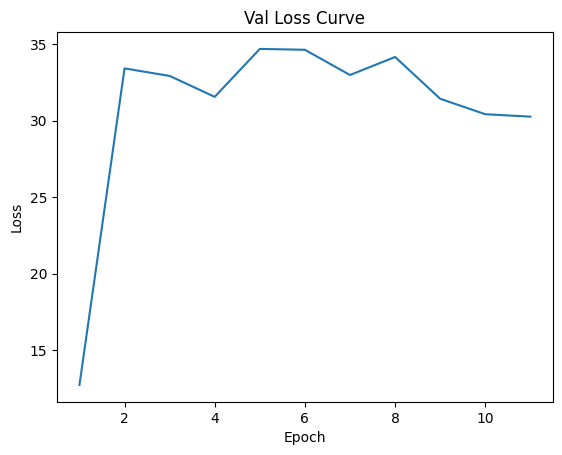

Student weights and architecture saved and exported for lambda: 5


In [28]:
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # load teacher model with lambda 0
    teacher_model = torch.load('teacher_model_rkd_wider_lambda02.pth')
    teacher_model.load_state_dict(torch.load('teacher_model_weights_rkd_wider_lambda02.pth'))
    teacher_model = teacher_model.to(device)
    
    # Reset the student model for each lambda
    student_model = torchvision.models.efficientnet_b0(weights=None)
    student_model.classifier = nn.Linear(1280, num_classes)
    student_optimizer = optim.Adam(student_model.parameters(), lr=best_lr_student)

    adv = Adversary()
    student_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_student)

    pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
    pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, adv_criterion, student_optimizer, device, alpha, temperature, epochs, lmda=i, patience=patience_student, optimizer_adv=student_optimizer_adv)

    torch.save(student_model.state_dict(), f'student_model_weights_rkd_wider_lambda{i}.pth')
    torch.save(student_model, f'student_model_rkd_wider_lambda{i}.pth')
    print('Student weights and architecture saved and exported for lambda:', i)

    # Update the dictionary with the student results
    if i in lambda_results:
        # If the key 'i' is already present in the dictionary
        lambda_results[i].update({
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        })
    else:
        # If the key 'i' is not present in the dictionary
        lambda_results[i] = {
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        }

In [29]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    inputs = inputs.to(device)

    teacher_time, student_time = 0, 0

    if teacher is not None:
        teacher = teacher.to(device)
        start_time = time.time()
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
        teacher_time = time.time() - start_time

    if student is not None:
        student = student.to(device)
        start_time = time.time()
        with torch.no_grad():
            student_outputs = student(inputs)
        student_time = time.time() - start_time
    
    return teacher_time, student_time


In [30]:
# # Loop through each lambda value
# lmda_list = lmda_list_student
# for lmda in lmda_list:
#     # Load teacher and student models for the current lambda
#     # teacher_model = torch.load(f'teacher_model_rkd_wider_lambda{lmda}.pth')
#     # student_model = torch.load(f'student_model_rkd_wider_lambda{lmda}.pth')

#     teacher_model = torch.load(f'teacher_model_rkd_wider_lambda02.pth')
#     student_model = torch.load(f'student_model_rkd_wider_lambda{lmda}.pth')


#     # Compute performance metrics
#     performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

#     # Compute model sizes and inference times
#     teacher_params, student_params = compare_model_size(teacher_model, student_model)
#     teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)

#     # Update results for the current lambda value
#     if lmda in lambda_results:
#         lambda_results[lmda].update({
#             'performance_metrics': performance_metrics,
#             'teacher_params': teacher_params,
#             'student_params': student_params,
#             'teacher_time': teacher_time,
#             'student_time': student_time
#         })
#     else:
#         lambda_results[lmda] = {
#             'performance_metrics': performance_metrics,
#             'teacher_params': teacher_params,
#             'student_params': student_params,
#             'teacher_time': teacher_time,
#             'student_time': student_time
#         }


In [35]:
# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    for lmda_student in lmda_list_student:

        # Load the teacher model for the current lambda from the 'output_dir'
        # teacher_model_path = os.path.join(output_dir, f'teacher_model_rkd_wider_lambda{lmda_teacher}.pth')
        teacher_model_path =f'teacher_model_rkd_wider_lambda02.pth'
        teacher_model = torch.load(teacher_model_path)
        
        # Load the student model for the current lambda from the 'output_dir'
        # student_model_path = os.path.join(output_dir, f'student_model_rkd_wider_lambda{lmda_student}.pth')
        student_model_path = f'student_model_rkd_wider_lambda{lmda_student}.pth'
        student_model = torch.load(student_model_path)
    
        # Compute performance metrics
        performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    
        # Compute model sizes
        teacher_params, student_params = compare_model_size(teacher_model, student_model)
    
        # Construct a unique key for the current combination of lambda values
        lambda_key = (lmda_teacher, lmda_student)

        # Update results for the current lambda value
        if lambda_key in lambda_results:
            lambda_results[lambda_key].update({
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            })
        else:
            lambda_results[lambda_key] = {
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            }


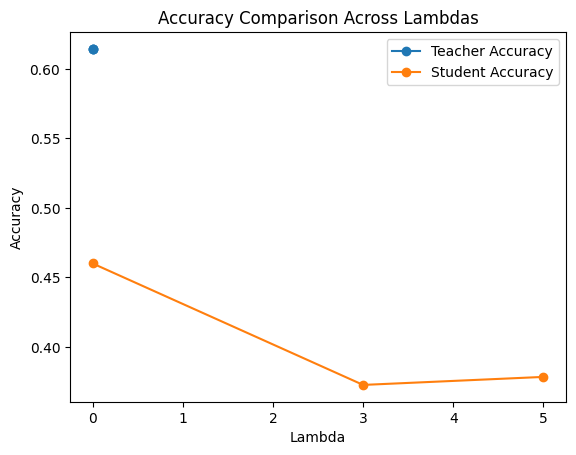

In [36]:
# Initialize lists to store accuracies
teacher_accuracies = []
student_accuracies = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Access the performance metrics for each pair
    teacher_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][0]
    student_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][1]

    # Append accuracies to the lists
    teacher_accuracies.append((lmda_teacher, teacher_accuracy))
    student_accuracies.append((lmda_student, student_accuracy))

# To plot, you might need to separate the lambda values and accuracies
teacher_lambdas, teacher_acc = zip(*teacher_accuracies)
student_lambdas, student_acc = zip(*student_accuracies)

# Plotting
plt.plot(teacher_lambdas, teacher_acc, label='Teacher Accuracy', marker='o')
plt.plot(student_lambdas, student_acc, label='Student Accuracy', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()
plt.show()


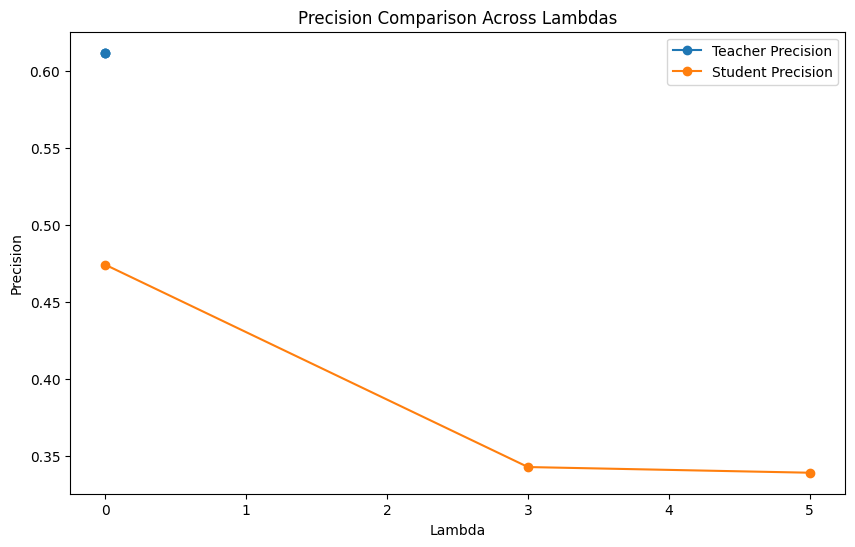

In [37]:
# Initialize lists to store precisions
teacher_precisions = []
student_precisions = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the precision metrics for each pair
        teacher_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][0]
        student_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append precisions to the lists along with lambda values
    teacher_precisions.append((lmda_teacher, teacher_precision))
    student_precisions.append((lmda_student, student_precision))

# To plot, you might need to separate the lambda values and precisions
teacher_lambdas, teacher_prec = zip(*teacher_precisions)
student_lambdas, student_prec = zip(*student_precisions)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_prec, label='Teacher Precision', marker='o')
plt.plot(student_lambdas, student_prec, label='Student Precision', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()
plt.show()


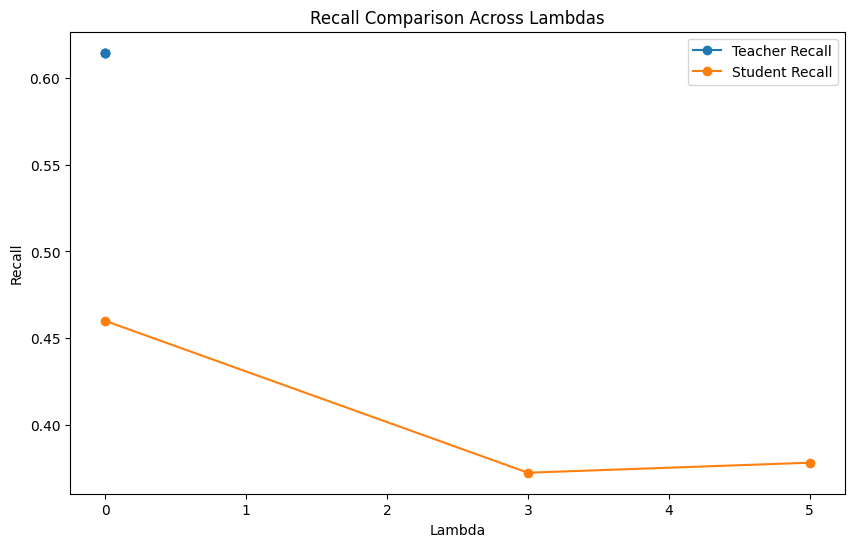

In [38]:
# Initialize lists to store recalls
teacher_recalls = []
student_recalls = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the recall metrics for each pair
        teacher_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][0]
        student_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append recalls to the lists along with lambda values
    teacher_recalls.append((lmda_teacher, teacher_recall))
    student_recalls.append((lmda_student, student_recall))

# To plot, you might need to separate the lambda values and recalls
teacher_lambdas, teacher_rec = zip(*teacher_recalls)
student_lambdas, student_rec = zip(*student_recalls)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_rec, label='Teacher Recall', marker='o')
plt.plot(student_lambdas, student_rec, label='Student Recall', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()
plt.show()

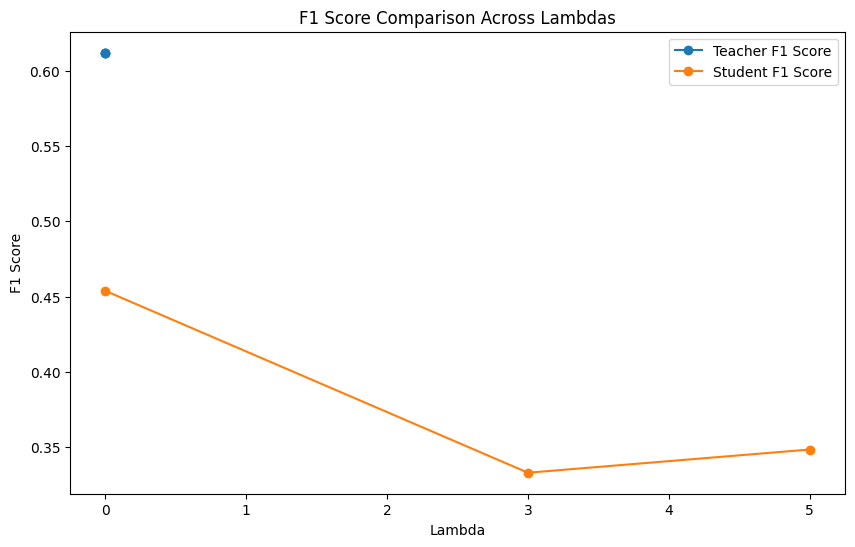

In [39]:
# Initialize lists to store F1 scores
teacher_f1s = []
student_f1s = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the F1 scores for each pair
        teacher_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][0]
        student_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append F1 scores to the lists along with lambda values
    teacher_f1s.append((lmda_teacher, teacher_f1))
    student_f1s.append((lmda_student, student_f1))

# To plot, you might need to separate the lambda values and F1 scores
teacher_lambdas, teacher_f1_scores = zip(*teacher_f1s)
student_lambdas, student_f1_scores = zip(*student_f1s)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_f1_scores, label='Teacher F1 Score', marker='o')
plt.plot(student_lambdas, student_f1_scores, label='Student F1 Score', marker='o')
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()
plt.show()

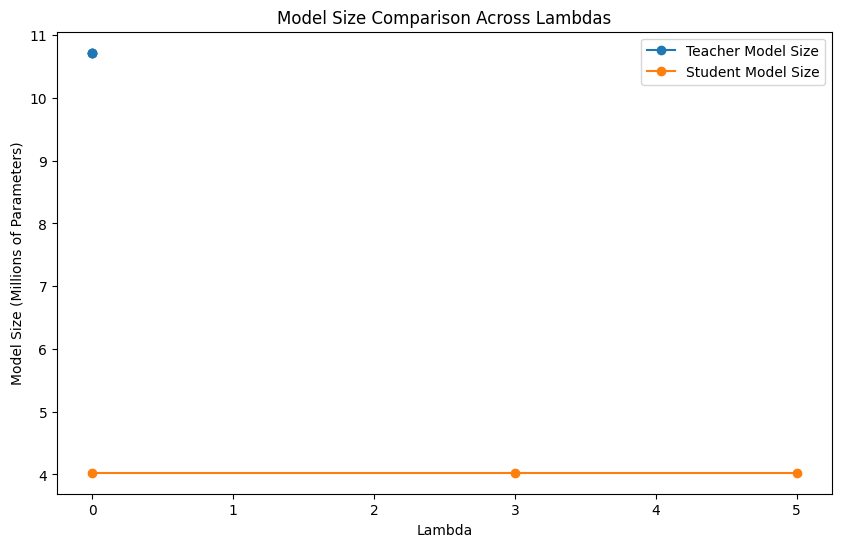

In [40]:
# Initialize lists to store model sizes
teacher_sizes = []
student_sizes = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the model sizes for each pair
        teacher_size = lambda_results[(lmda_teacher, lmda_student)]['teacher_params'] / 1e6  # Convert to millions
        student_size = lambda_results[(lmda_teacher, lmda_student)]['student_params'] / 1e6
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append model sizes to the lists along with lambda values
    teacher_sizes.append((lmda_teacher, teacher_size))
    student_sizes.append((lmda_student, student_size))

# To plot, you might need to separate the lambda values and model sizes
teacher_lambdas, teacher_model_sizes = zip(*teacher_sizes)
student_lambdas, student_model_sizes = zip(*student_sizes)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_model_sizes, label='Teacher Model Size', marker='o')
plt.plot(student_lambdas, student_model_sizes, label='Student Model Size', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()
plt.show()

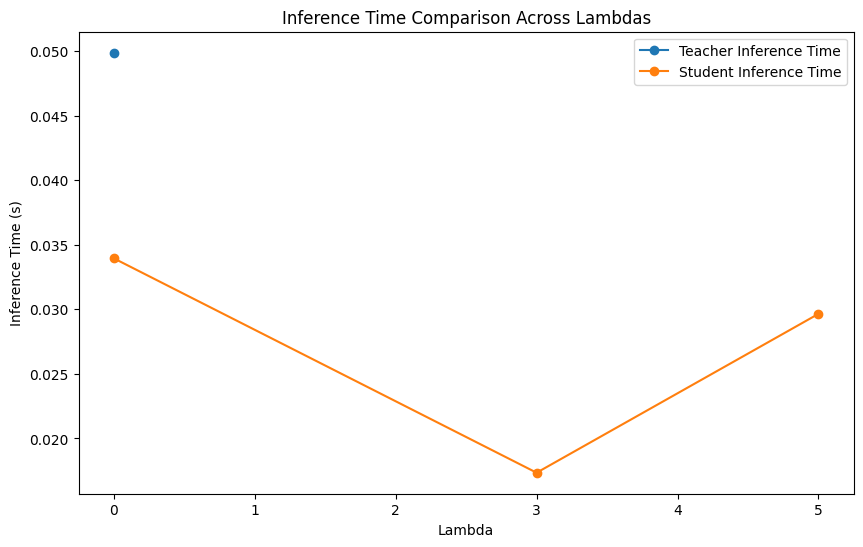

In [43]:
# Initialize dictionaries to store inference times for each lambda value
teacher_times = {}
student_times = {}

# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model for the current lambda
    # teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
    teacher_model_path = f'teacher_model_rkd_wider_lambda02.pth'
    teacher_model = torch.load(teacher_model_path)

    teacher_time, _ = compare_inference_time(teacher_model, None, testloader)
    teacher_times[lmda_teacher] = teacher_time  # Store the inference time for the teacher model

for lmda_student in lmda_list_student:
    # Load the student model for the current lambda
    # student_model_path = os.path.join(output_dir, f'student_model_rkd_wider_lambda{lmda_student}.pth')
    student_model_path = f'student_model_rkd_wider_lambda{lmda_student}.pth'
    student_model = torch.load(student_model_path)

    _, student_time = compare_inference_time(None, student_model, testloader)
    student_times[lmda_student] = student_time  # Store the inference time for the student model

# Prepare data for plotting
teacher_lambdas, teacher_inference_times = zip(*teacher_times.items())
student_lambdas, student_inference_times = zip(*student_times.items())

plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_inference_times, label='Teacher Inference Time', marker='o')
plt.plot(student_lambdas, student_inference_times, label='Student Inference Time', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()
plt.show()

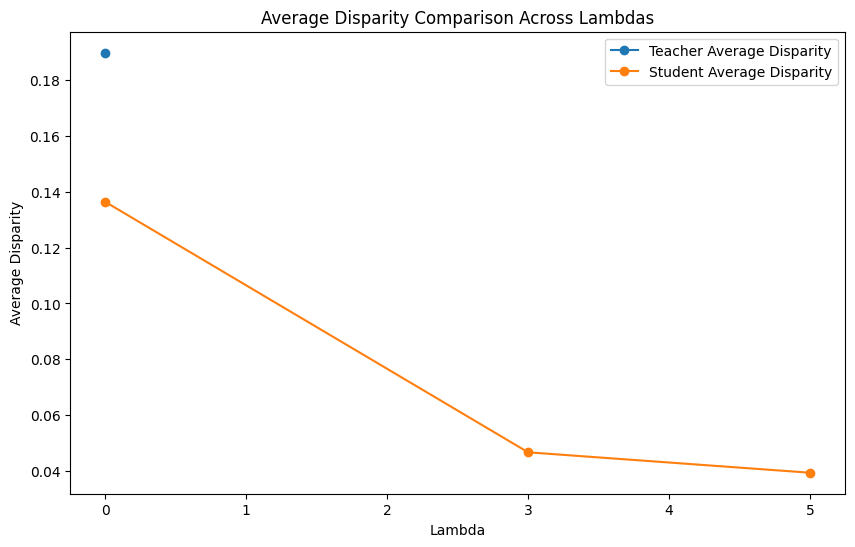

In [44]:
# Initialize lists to store disparity values
teacher_disparities = []
student_disparities = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if it's an integer key (indicating a lambda value for student)
    if isinstance(key, int):
        # Check and extract teacher disparity if it exists
        if 'teacher_mean_abs_val_disparity' in lambda_results[key]:
            teacher_disparity = lambda_results[key]['teacher_mean_abs_val_disparity']
            if isinstance(teacher_disparity, list):  # Assuming the disparity could be stored as a list
                teacher_disparity = teacher_disparity[0]
            teacher_disparities.append((key, teacher_disparity))

        # Extract student disparity
        if 'student_mean_abs_val_disparity' in lambda_results[key]:
            student_disparity = lambda_results[key]['student_mean_abs_val_disparity']
            student_disparities.append((key, student_disparity))

# Separate the lambda values and disparity values
teacher_lambdas, teacher_disparity_values = zip(*teacher_disparities) if teacher_disparities else ([], [])
student_lambdas, student_disparity_values = zip(*student_disparities) if student_disparities else ([], [])

# Plotting
plt.figure(figsize=(10, 6))
if teacher_disparities:
    plt.plot(teacher_lambdas, teacher_disparity_values, label='Teacher Average Disparity', marker='o')
if student_disparities:
    plt.plot(student_lambdas, student_disparity_values, label='Student Average Disparity', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()
plt.show()

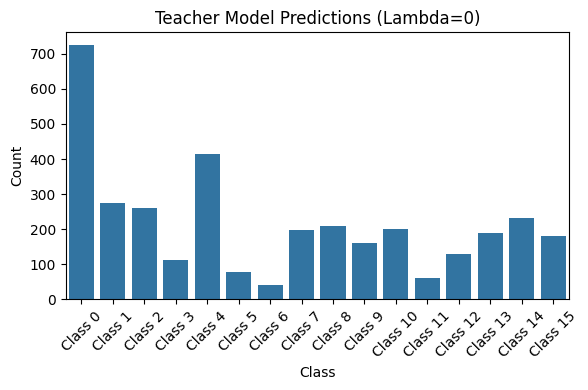

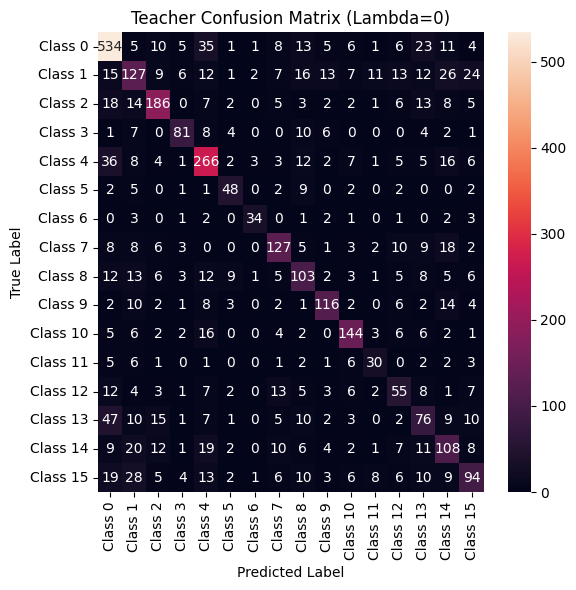

Classification Report - Teacher Model (Lambda=0)
              precision    recall  f1-score   support

     Class 0       0.74      0.80      0.77       668
     Class 1       0.46      0.42      0.44       301
     Class 2       0.71      0.68      0.70       272
     Class 3       0.73      0.65      0.69       124
     Class 4       0.64      0.71      0.67       377
     Class 5       0.62      0.65      0.64        74
     Class 6       0.81      0.68      0.74        50
     Class 7       0.64      0.63      0.64       202
     Class 8       0.50      0.53      0.51       194
     Class 9       0.72      0.67      0.69       173
    Class 10       0.72      0.72      0.72       199
    Class 11       0.49      0.50      0.50        60
    Class 12       0.42      0.43      0.42       129
    Class 13       0.40      0.38      0.39       198
    Class 14       0.46      0.49      0.48       220
    Class 15       0.52      0.42      0.47       224

    accuracy                   

FileNotFoundError: [Errno 2] No such file or directory: 'student_model_ckd_wider_lambda0.pth'

In [47]:
def plot_distribution(predictions, class_names, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=predictions)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, predictions, class_names, title):
    cm = confusion_matrix(all_labels, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Function to generate predictions and compute metrics
def generate_predictions_and_metrics(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['img'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds)

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return all_labels, all_preds

# Loop over each lambda value for the teacher model
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model from the 'output_dir'
    # teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
    teacher_model_path = f'teacher_model_rkd_wider_lambda02.pth'
    teacher_model = torch.load(teacher_model_path)

    # Generate predictions for the teacher model
    all_labels, all_teacher_preds = generate_predictions_and_metrics(teacher_model, testloader)

    # Plot distribution and confusion matrix for the teacher model
    plot_distribution(all_teacher_preds, class_names_new, f'Teacher Model Predictions (Lambda={lmda_teacher})')
    plot_confusion_matrix(all_labels, all_teacher_preds, class_names_new, f'Teacher Confusion Matrix (Lambda={lmda_teacher})')

    # Print classification report for the teacher model
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda_teacher})')
    print(teacher_report)

# Loop over each lambda value for the student model
for lmda_student in lmda_list_student:
    # Load the student model from the 'output_dir'
    # student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
    student_model_path = f'student_model_ckd_wider_lambda{lmda_student}.pth'
    student_model = torch.load(student_model_path)

    # Generate predictions for the student model
    all_labels, all_student_preds = generate_predictions_and_metrics(student_model, testloader)

    # Plot distribution and confusion matrix for the student model
    plot_distribution(all_student_preds, class_names_new, f'Student Model Predictions (Lambda={lmda_student})')
    plot_confusion_matrix(all_labels, all_student_preds, class_names_new, f'Student Confusion Matrix (Lambda={lmda_student})')

    # Print classification report for the student model
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Student Model (Lambda={lmda_student})')
    print(student_report)

In [ ]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    bias_values = []
    accuracy_values = []

    if model_type == 'teacher':
        for lmda in lambdas:
            if lmda in model_results and 'teacher_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['teacher_mean_abs_val_disparity'][0])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[0] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][0])
        model_name = "Teacher"
    elif model_type == 'student':
        for lmda in lambdas:
            if lmda in model_results and 'student_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['student_mean_abs_val_disparity'])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[1] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][1])
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")


    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")
    
# Plot for Teacher
plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list_teacher)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)


In [ ]:
def compare_performance_metrics_for_demo(teacher, student, dataloader):
    teacher.eval()
    student.eval()

    detailed_info = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        # Assuming gender or other attributes are part of 'target'
        attributes = batch['target'].to(device)  

        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)

        teacher_preds = torch.argmax(teacher_outputs, dim=1)
        student_preds = torch.argmax(student_outputs, dim=1)

        for i in range(inputs.size(0)):
            if teacher_preds[i] != labels[i] and student_preds[i] == labels[i]:
                info = {
                    'image': inputs[i],
                    'actual_class': labels[i].item(),
                    'teacher_pred_class': teacher_preds[i].item(),
                    'student_pred_class': student_preds[i].item(),
                    'actual_attribute': attributes[i].item(),  # Modify based on your dataset
                    # If your model also predicts attributes, include them here
                }
                detailed_info.append(info)

    return detailed_info

In [ ]:
def plot_images_with_details(info_list, rows=5, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(rows * cols):
        if i < len(info_list):
            data = info_list[i]
            image = data['image']
            actual_class = data['actual_class']
            teacher_pred_class = data['teacher_pred_class']
            student_pred_class = data['student_pred_class']
            actual_attribute = round(data['actual_attribute'], 2)  # Round to 2 decimal places

            # Normalize the image for display
            image_display = image.cpu().numpy().transpose(1, 2, 0)
            image_display = (image_display - image_display.min()) / (image_display.max() - image_display.min())

            title = f'Actual: Class {actual_class}, Attr {actual_attribute}\n' + \
                    f'Teacher: Class {teacher_pred_class}\n' + \
                    f'Student: Class {student_pred_class}'

            axes[i].imshow(image_display)
            axes[i].set_title(title)
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()


In [ ]:
# Get detailed info where student is correct and teacher is wrong
detailed_info = compare_performance_metrics_for_demo(teacher_model, student_model, testloader)

# Display images with details
plot_images_with_details(detailed_info)